In [130]:
import json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import savgol_filter, find_peaks
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
def gompertz(t, A, mu, l):
    log_B = A * np.exp(-np.exp(mu * np.exp(1) / A * (l - t) + 1))
    return log_B

In [18]:
def gompertz_growth_rate(t, A, mu, l):
    gr = mu * np.exp(np.exp(1) * mu * (l - t) / A - np.exp(np.exp(1) * mu * (l - t) / A + 1) + 2)
    return gr

In [17]:
def tm_gomp(A, mu, l):
    return A / (mu * np.e) + l

In [3]:
exp_sum = pd.read_excel('../Exps_summary.xlsx')
positions = pd.read_excel('../Positions.xlsx')

df = pd.read_excel('../data_processed.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')

pos_grouped = positions.groupby(['Date', 'Machine', 'Pad'])['colonies'].sum().reset_index()
pos_grouped.rename(columns={'colonies': 'total_colonies'}, inplace=True)

# Group by 'Date', 'Machine', and 'Pad' and calculate mean, std, and count of 'area_max_um'
agg_colony_area_df = df.groupby(['Date', 'Machine', 'Pad'])['area_max_um'].agg(['mean', 'std', 'count']).reset_index()

# Rename the columns for clarity
agg_colony_area_df.rename(columns={'mean': 'mean_colony_area', 'std': 'std_colony_area', 'count': 'num_colonies'}, inplace=True)

# Merge the grouped data from 'positions' and the aggregated colony area data from 'df'
df_N_A = pd.merge(pos_grouped, agg_colony_area_df, on=['Date', 'Machine', 'Pad'], how='inner')

# Display the merged dataframe
df_N_A.head()

Date      Machine  Pad  total_colonies  mean_colony_area  \
0 2023-11-15     Ti scope    1            19.0     127494.473143   
1 2023-11-15     Ti scope    2            23.0      46725.168600   
2 2023-11-15  Tweez scope    1             3.0     768482.640000   
3 2023-11-15  Tweez scope    2             1.0     476031.532500   
4 2023-11-17     Ti scope    1             6.0     366810.583800   

   std_colony_area  num_colonies  
0     21643.298316             7  
1     15593.763903             2  
2     99168.204670             2  
3              NaN             1  
4     47734.937249             6

#### A*N vs N

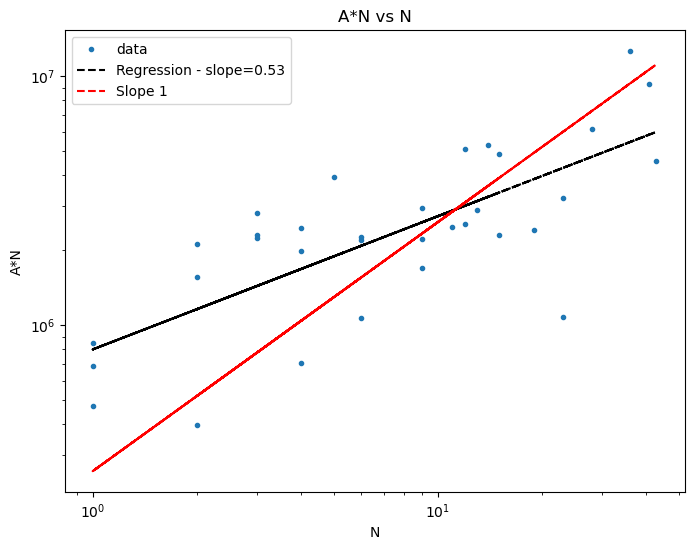

In [4]:
AN = df_N_A['total_colonies'] * df_N_A['mean_colony_area']

# linear regression in log-log space
log_N = np.log10(df_N_A['total_colonies'])
log_AN = np.log10(AN)

# fit the regression model (linear fit in log-log space)
slope, intercept = np.polyfit(log_N, log_AN, 1)
# create the regression line in log-log space
regression_line = 10**(slope * log_N + intercept)

# Calculate the scaling factor to align the slope 1 line with the data
scaling_factor = (df_N_A['total_colonies'] * df_N_A['mean_colony_area']).mean() / df_N_A['total_colonies'].mean()
# Plotting a slope 1 line for reference in log-log space, scaled to match the data
slope_1_line = scaling_factor * df_N_A['total_colonies']  # Slope 1 line

plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')

plt.plot(df_N_A['total_colonies'], AN, '.', label='data')
plt.plot(df_N_A['total_colonies'], regression_line, '--', label=f'Regression - slope={slope:.2f}', color='black')
plt.plot(df_N_A['total_colonies'], slope_1_line, '--', label='Slope 1', color='red')

plt.ylabel('A*N')
plt.xlabel('N')
plt.title('A*N vs N')

plt.legend()

plt.show()

#### Gompertz params vs N

In [5]:
df_gomp = df.groupby(['Date','Machine','Pad'])[['A_gomp_um','mu_gomp_um','l_gomp_um']].agg(['mean','std']).reset_index()
df_gomp.columns = ['_'.join(filter(None, col)).strip('_') for col in df_gomp.columns.values]
df_gomp.head()

Date      Machine  Pad  A_gomp_um_mean  A_gomp_um_std  \
0 2023-11-15     Ti scope    1   124844.505297   21029.802963   
1 2023-11-15     Ti scope    2    44951.936568   14489.775612   
2 2023-11-15  Tweez scope    1   761776.515325   97483.118497   
3 2023-11-15  Tweez scope    2   469881.069646            NaN   
4 2023-11-17     Ti scope    1   362891.221616   47016.657638   

   mu_gomp_um_mean  mu_gomp_um_std  l_gomp_um_mean  l_gomp_um_std  
0       414.191407       76.516590      347.800191      14.380969  
1       115.569528       45.912740      390.868408      13.372949  
2      1649.906803       39.333283      438.492732      32.238057  
3      1050.361432             NaN      423.652960            NaN  
4       801.770163      124.341047      373.917657      12.847217

In [6]:
# merge total colonies and average area with gompertz params dataframes
df_N_A_gomp = pd.merge(df_gomp, df_N_A, on=['Date', 'Machine', 'Pad'], how='inner')

# Display the merged dataframe
df_N_A_gomp.head()

Date      Machine  Pad  A_gomp_um_mean  A_gomp_um_std  \
0 2023-11-15     Ti scope    1   124844.505297   21029.802963   
1 2023-11-15     Ti scope    2    44951.936568   14489.775612   
2 2023-11-15  Tweez scope    1   761776.515325   97483.118497   
3 2023-11-15  Tweez scope    2   469881.069646            NaN   
4 2023-11-17     Ti scope    1   362891.221616   47016.657638   

   mu_gomp_um_mean  mu_gomp_um_std  l_gomp_um_mean  l_gomp_um_std  \
0       414.191407       76.516590      347.800191      14.380969   
1       115.569528       45.912740      390.868408      13.372949   
2      1649.906803       39.333283      438.492732      32.238057   
3      1050.361432             NaN      423.652960            NaN   
4       801.770163      124.341047      373.917657      12.847217   

   total_colonies  mean_colony_area  std_colony_area  num_colonies  
0            19.0     127494.473143     21643.298316             7  
1            23.0      46725.168600     15593.763903             2  
2             3.0     768482.640000     99168.204670             2  
3             1.0     476031.532500              NaN             1  
4             6.0     366810.583800     47734.937249             6

In [8]:
pos_grouped = positions.groupby(['Date', 'Machine', 'Pad'])['colonies'].sum().reset_index()
pos_grouped.rename(columns={'colonies': 'total_colonies'}, inplace=True)

# Merge the grouped data back into the original DataFrame
df_N_A_gomp_all_pos = df.merge(pos_grouped, on=['Date', 'Machine', 'Pad'], how='left')

# Display the updated DataFrame
df_N_A_gomp_all_pos.head()

Date   Machine  Position  Strain            DNA Chemical  Pad  \
0 2023-11-15  Ti scope         0  MC4100  pLPT20&pLPT41        -    1   
1 2023-11-15  Ti scope         1  MC4100  pLPT20&pLPT41        -    1   
2 2023-11-15  Ti scope         3  MC4100  pLPT20&pLPT41        -    1   
3 2023-11-15  Ti scope         6  MC4100  pLPT20&pLPT41        -    1   
4 2023-11-15  Ti scope         7  MC4100  pLPT20&pLPT41        -    1   

  Dilution   t_incub      t_im  ...  \
0  10^(-5)  09:25:00  14:41:00  ...   
1  10^(-5)  09:25:00  14:41:00  ...   
2  10^(-5)  09:25:00  14:41:00  ...   
3  10^(-5)  09:25:00  14:41:00  ...   
4  10^(-5)  09:25:00  14:41:00  ...   

                                  gompertz_params_um  \
0  {"A": 103786.40790791844, "mu_m": 343.23543623...   
1  {"A": 148648.90367592312, "mu_m": 486.68730573...   
2  {"A": 138470.39089115502, "mu_m": 463.74330876...   
3  {"A": 100919.60615120828, "mu_m": 319.21789925...   
4  {"A": 131433.34449968569, "mu_m": 451.35651782...   

                                  gompertz_params_px  t_m_gomp_px t_m_gomp_um  \
0  {"A": 11.294671508124804, "mu_m": 0.0342966593...   196.233902  192.652257   
1  {"A": 11.651550812528813, "mu_m": 0.0365208066...   189.071354  185.759151   
2  {"A": 11.58037734670003, "mu_m": 0.03699176718...   180.608968  177.383564   
3  {"A": 11.263179138756406, "mu_m": 0.0342345062...   151.439105  148.045616   
4  {"A": 11.528274939059358, "mu_m": 0.0376935025...   186.954020  183.773603   

       r0_um      A_gomp_um  mu_gomp_um   l_gomp_um  gomp_growth_stops_10  \
0  25.726989  103786.407908  343.235436  366.413055                   982   
1  37.567485  148648.903676  486.687306  354.501107                  1015   
2  50.002925  138470.390891  463.743309  343.273546                   984   
3  23.368757  100919.606151  319.217899  320.089585                   955   
4  35.216651  131433.344500  451.356518  345.419708                   968   

   total_colonies  
0            19.0  
1            19.0  
2            19.0  
3            19.0  
4            19.0  

[5 rows x 45 columns]

#### A vs area_max_um

Text(0.5, 0, 'Area')

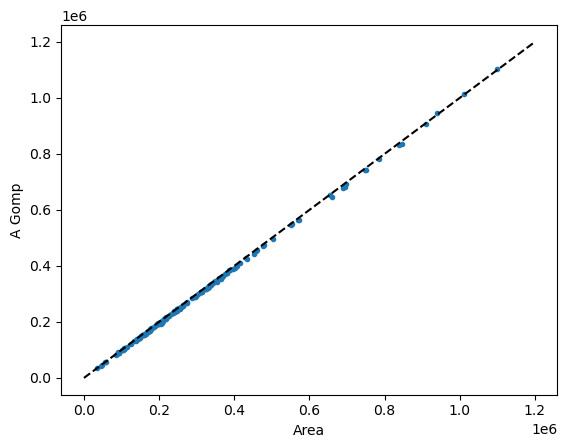

In [33]:
plt.plot(df['area_max_um'],df['A_gomp_um'],'.')
plt.plot(np.arange(0,1.2e6), np.arange(0,1.2e6), 'k--')
plt.xlabel('Area mask')
plt.ylabel('A Gomp')

#### A vs N

Text(0.5, 0, 'N')

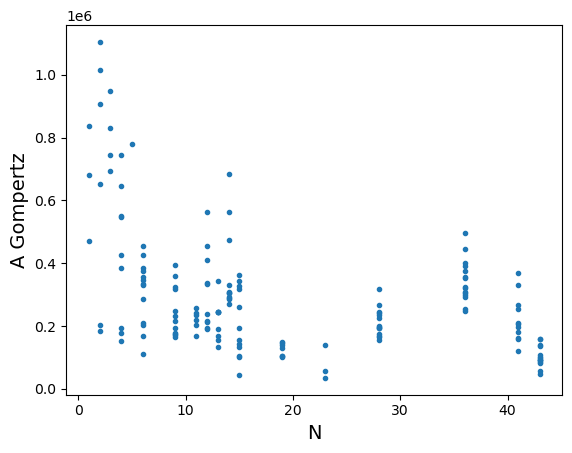

In [49]:
#plt.yscale('log')
plt.plot(df_N_A_gomp_all_pos['total_colonies'],df_N_A_gomp_all_pos['A_gomp_um'],'.')
plt.ylabel('A Gompertz',fontsize=14)
plt.xlabel('N',fontsize=14)

#### $\mu_m$ vs N

Text(0.5, 0, 'N')

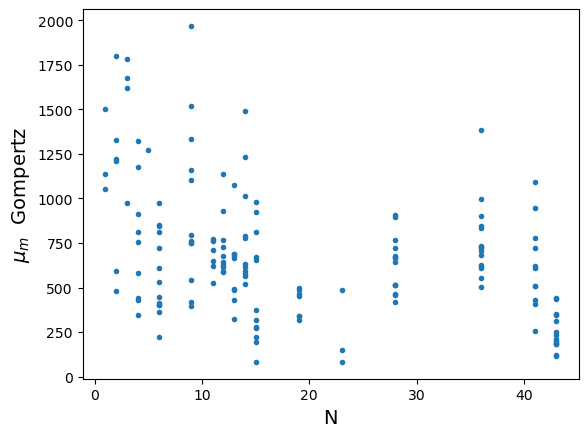

In [50]:
plt.plot(df_N_A_gomp_all_pos['total_colonies'],df_N_A_gomp_all_pos['mu_gomp_um'],'.')
plt.ylabel('$\mu_m$  Gompertz',fontsize=14)
plt.xlabel('N',fontsize=14)

#### $\lambda$ vs N

Text(0.5, 0, 'N')

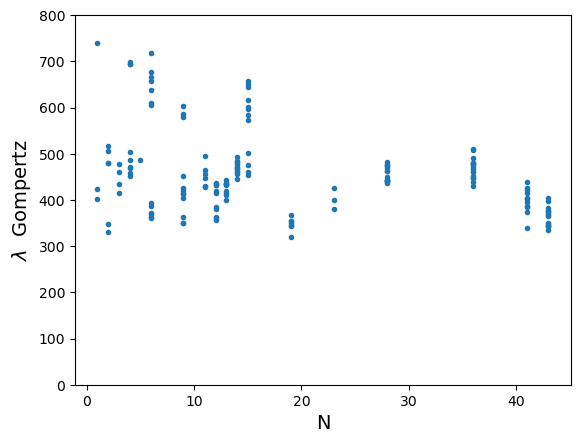

In [51]:
plt.plot(df_N_A_gomp_all_pos['total_colonies'],df_N_A_gomp_all_pos['l_gomp_um'],'.')
plt.ylabel('$\lambda$  Gompertz',fontsize=14)
plt.ylim([0,800])
plt.xlabel('N',fontsize=14)

#### $r_0$ vs N

Text(0.5, 0, 'N')

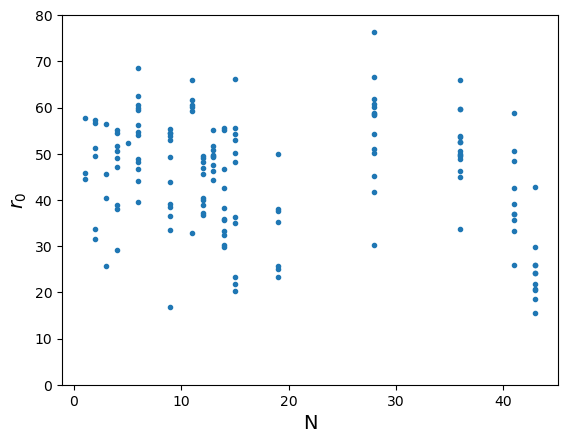

In [47]:
df_N_A_gomp_all_pos_r0 = df_N_A_gomp_all_pos[df_N_A_gomp_all_pos.r0_um>1]
plt.plot(df_N_A_gomp_all_pos_r0['total_colonies'],df_N_A_gomp_all_pos_r0['r0_um'],'.')
plt.ylabel('$r_0$',fontsize=14)
plt.ylim([0,80])
plt.xlabel('N',fontsize=14)

#### A vs $r_0$

Text(0, 0.5, 'A Gompertz')

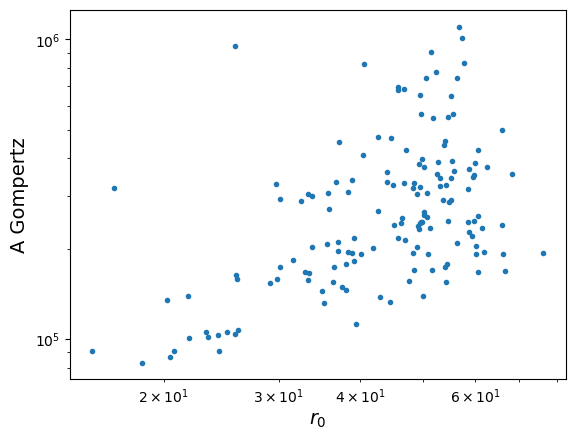

In [175]:
## more restrictions, it's costly
plt.yscale('log')
plt.xscale('log')
#df_N_A_gomp_all_pos_ = df_N_A_gomp_all_pos[df_N_A_gomp_all_pos.r0_um>1]
plt.plot(df_N_A_gomp_all_pos_r0['r0_um'],df_N_A_gomp_all_pos_r0['A_gomp_um'],'.')
plt.xlabel('$r_0$',fontsize=14)
#plt.ylim([0,80])
plt.ylabel('A Gompertz',fontsize=14)

Text(0, 0.5, 'A Gompertz')

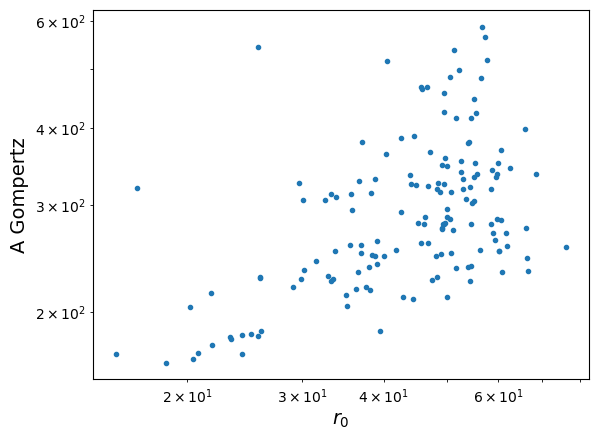

In [177]:
## more restrictions, it's costly
plt.yscale('log')
plt.xscale('log')

#df_N_A_gomp_all_pos_ = df_N_A_gomp_all_pos[df_N_A_gomp_all_pos.r0_um>1]
plt.plot(df_N_A_gomp_all_pos_r0['r0_um'],df_N_A_gomp_all_pos_r0['rad_max_um'],'.')
plt.xlabel('$r_0$',fontsize=14)
#plt.ylim([0,80])
plt.ylabel('A Gompertz',fontsize=14)

#### Time stops growth

0


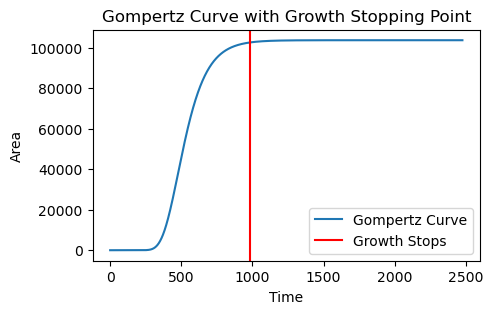

The colony stops growing around time: 982
1


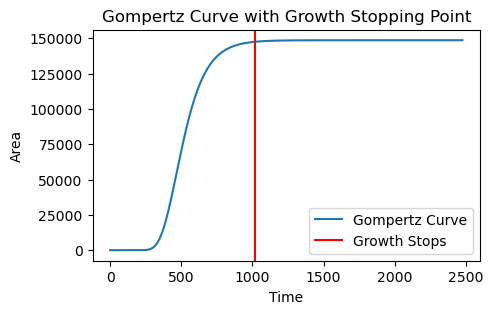

The colony stops growing around time: 1015
2


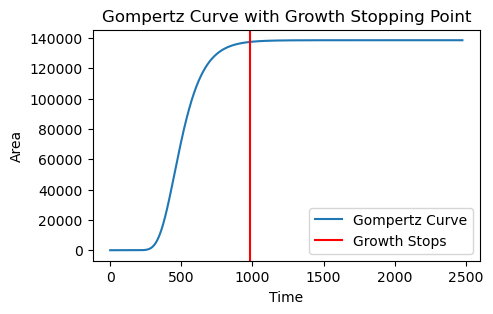

The colony stops growing around time: 984
3


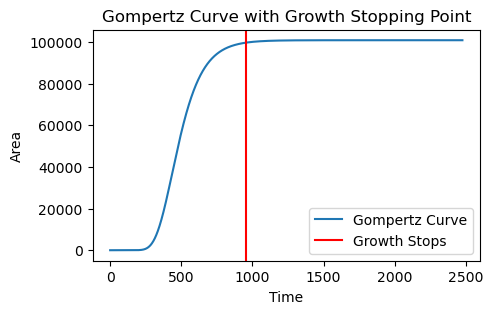

The colony stops growing around time: 955
4


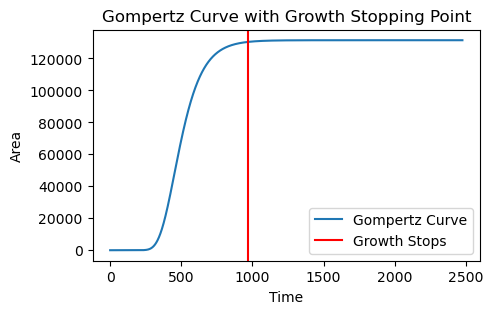

The colony stops growing around time: 968
5


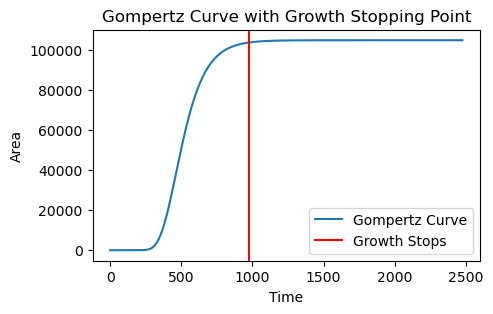

The colony stops growing around time: 976
6


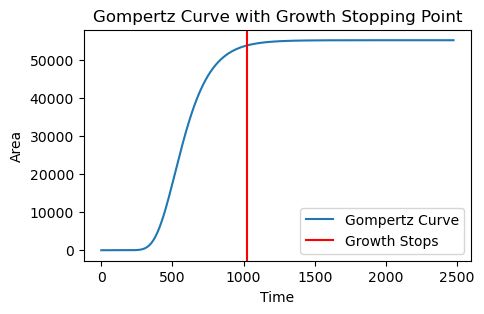

The colony stops growing around time: 1022
7


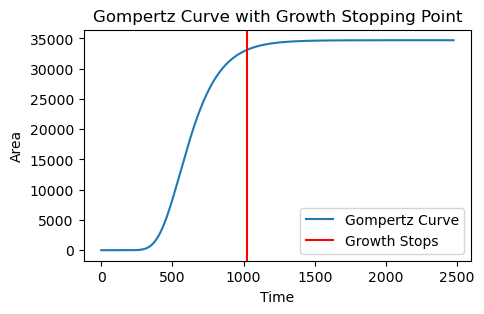

The colony stops growing around time: 1026
8


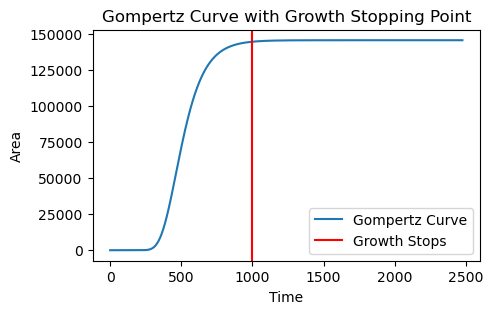

The colony stops growing around time: 995
9


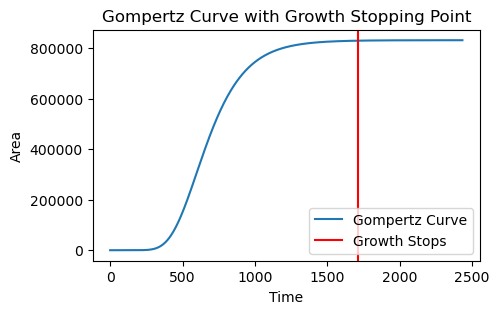

The colony stops growing around time: 1713
10


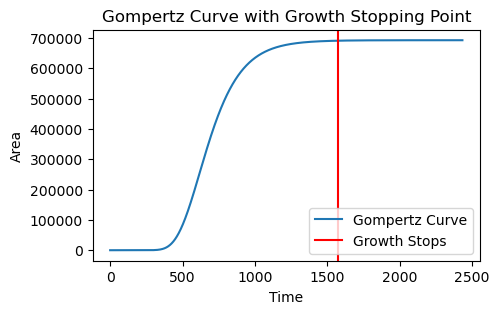

The colony stops growing around time: 1575
11


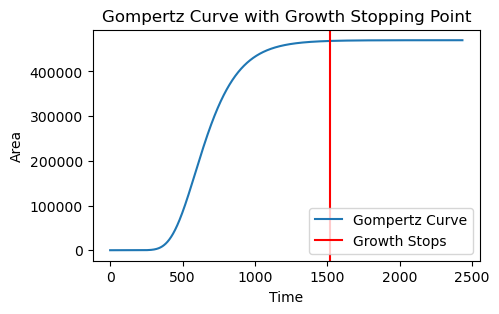

The colony stops growing around time: 1519
12


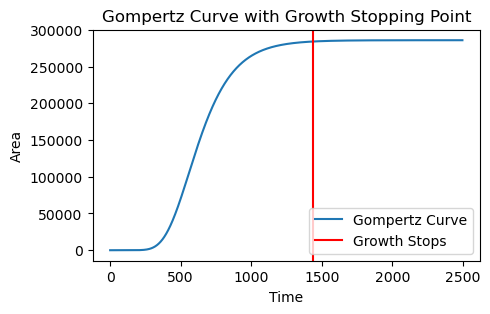

The colony stops growing around time: 1440
13


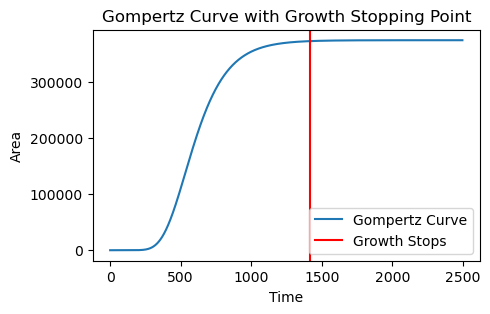

The colony stops growing around time: 1415
14


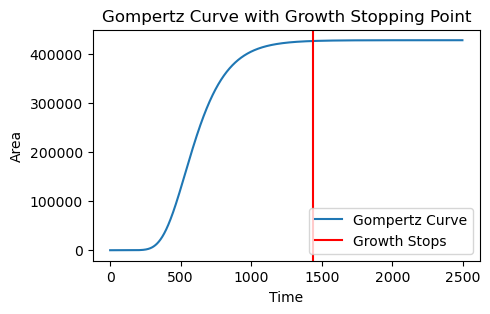

The colony stops growing around time: 1434
15


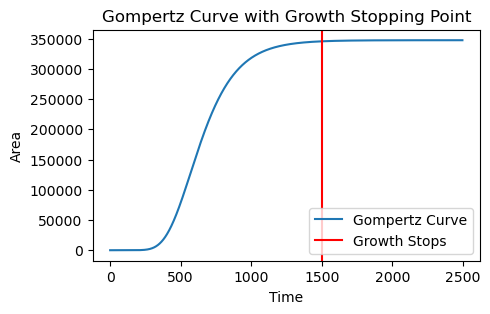

The colony stops growing around time: 1504
16


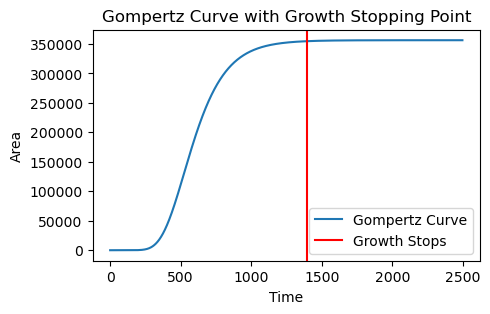

The colony stops growing around time: 1397
17


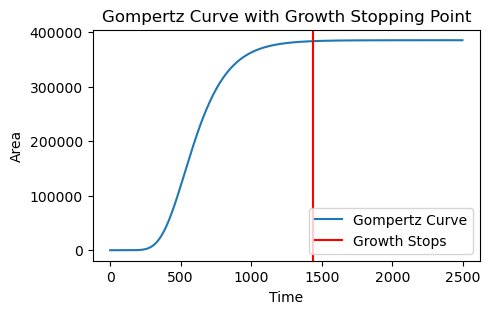

The colony stops growing around time: 1440
18


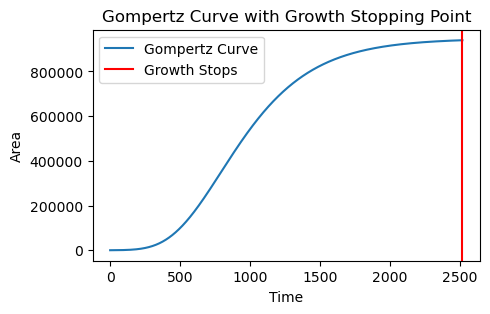

The colony stops growing around time: 2519
19


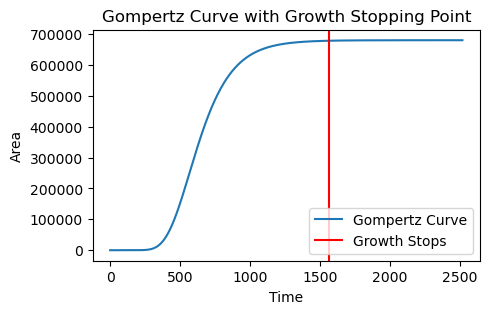

The colony stops growing around time: 1567
20


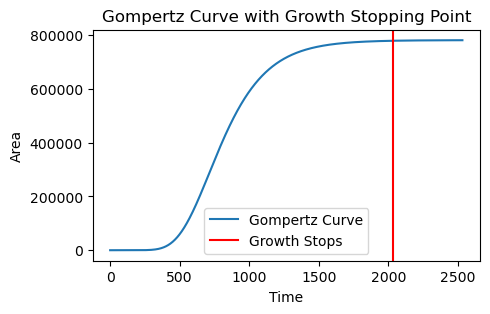

The colony stops growing around time: 2033
21


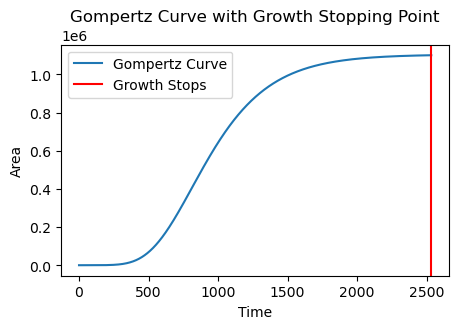

The colony stops growing around time: 2533
22


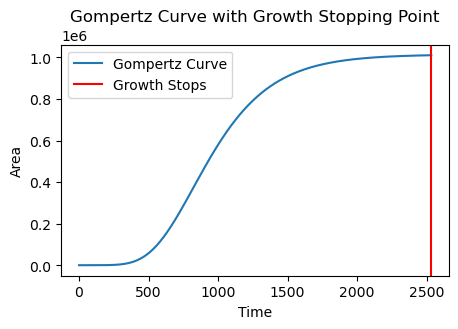

The colony stops growing around time: 2533
23


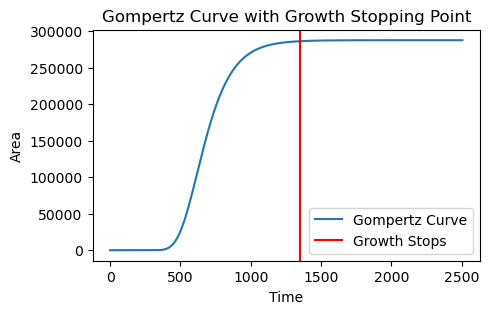

The colony stops growing around time: 1348
24


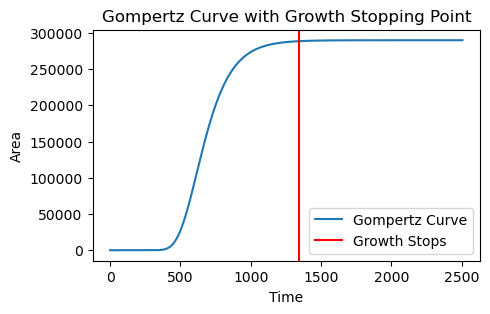

The colony stops growing around time: 1340
25


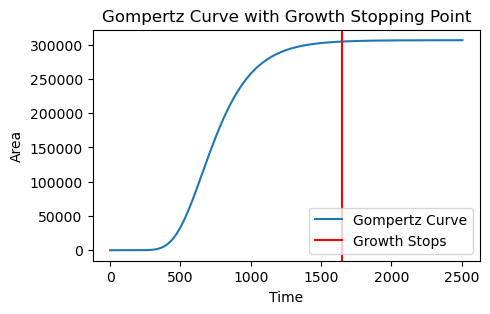

The colony stops growing around time: 1648
26


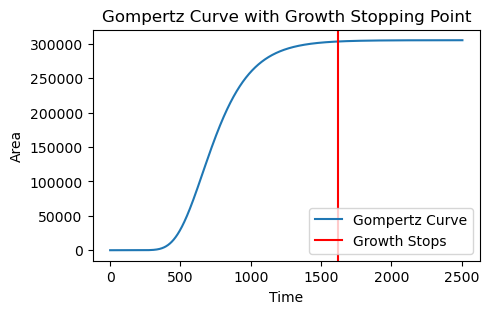

The colony stops growing around time: 1618
27


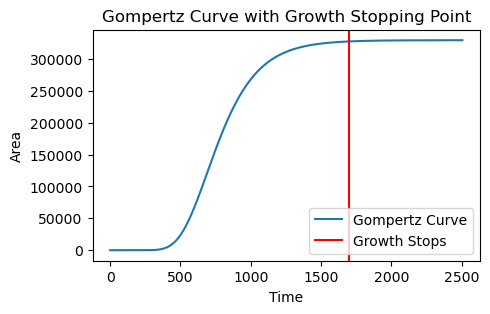

The colony stops growing around time: 1696
28


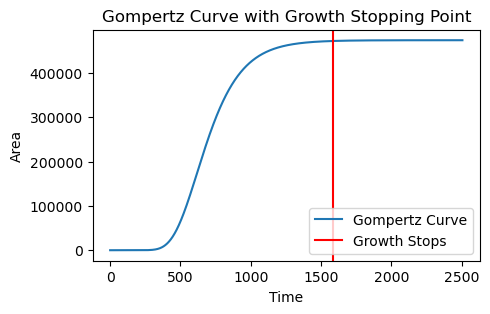

The colony stops growing around time: 1586
29


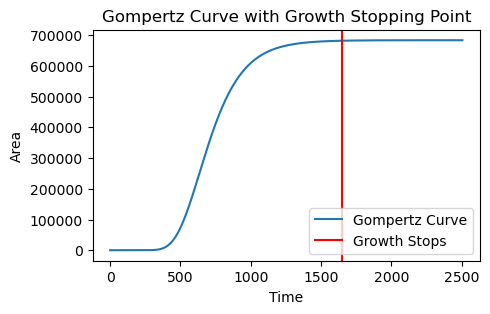

The colony stops growing around time: 1648
30


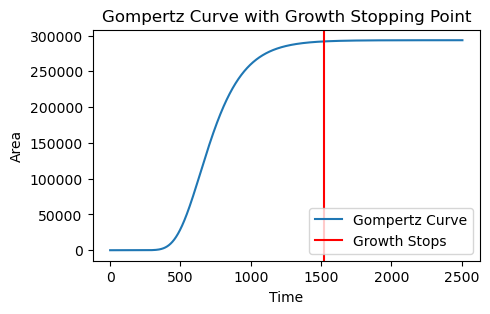

The colony stops growing around time: 1518
31


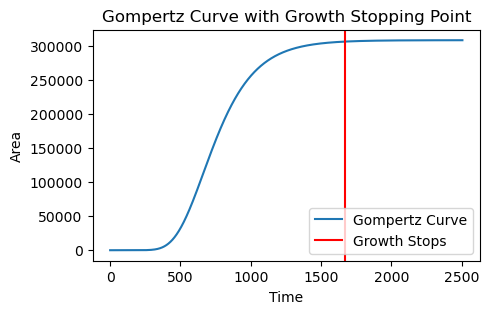

The colony stops growing around time: 1673
32


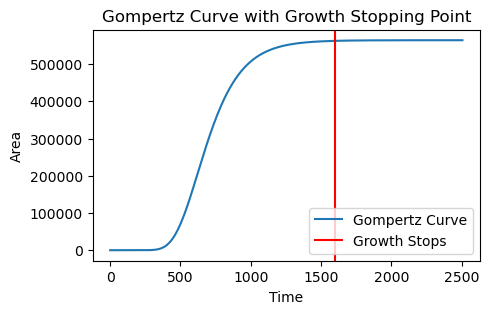

The colony stops growing around time: 1603
33


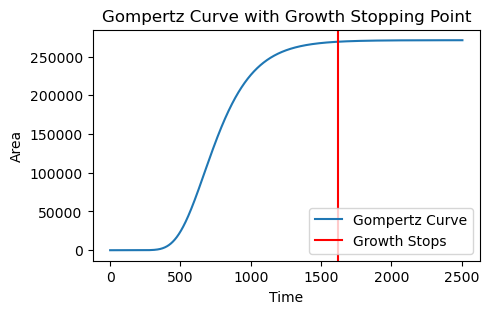

The colony stops growing around time: 1624
34


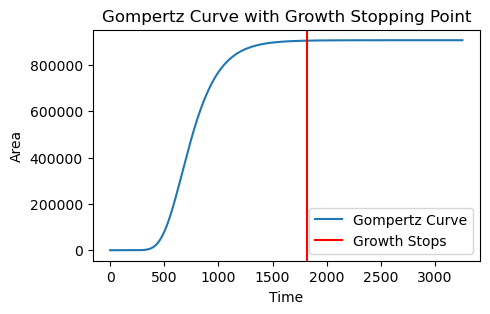

The colony stops growing around time: 1815
35


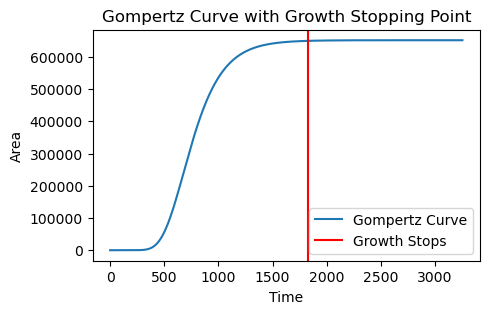

The colony stops growing around time: 1824
36


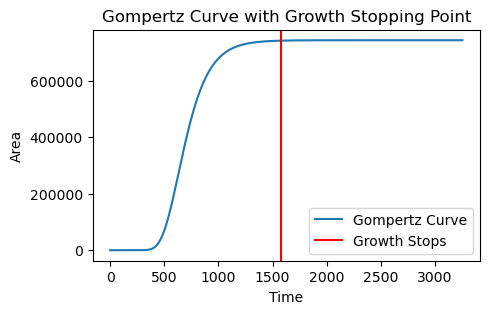

The colony stops growing around time: 1581
37


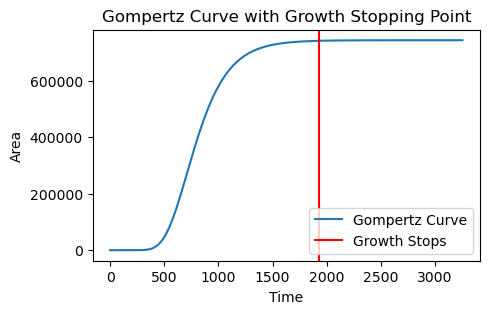

The colony stops growing around time: 1929
38


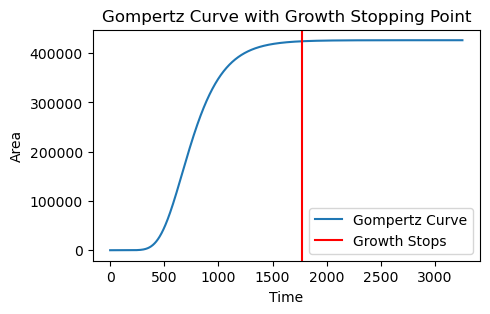

The colony stops growing around time: 1773
39


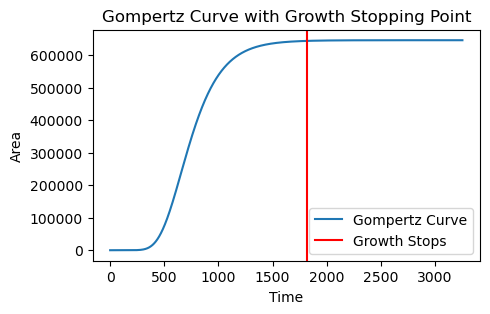

The colony stops growing around time: 1821
40


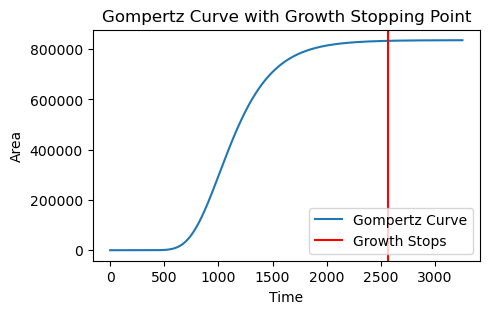

The colony stops growing around time: 2561
41


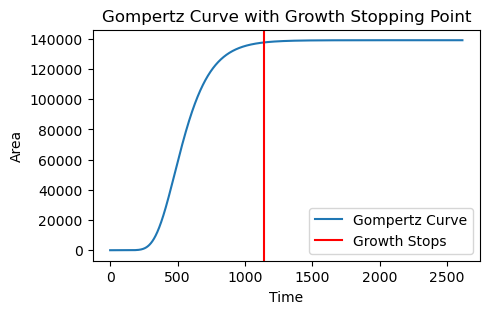

The colony stops growing around time: 1143
42


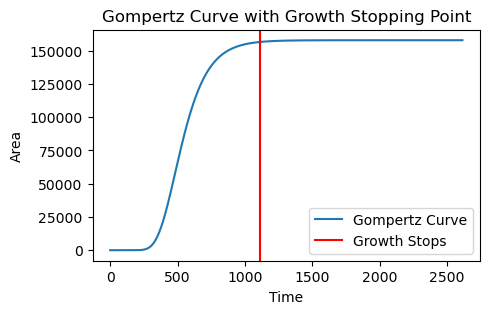

The colony stops growing around time: 1111
43


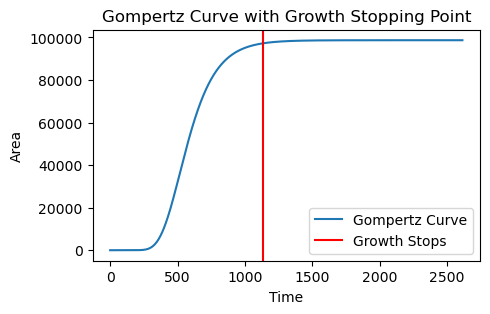

The colony stops growing around time: 1133
44


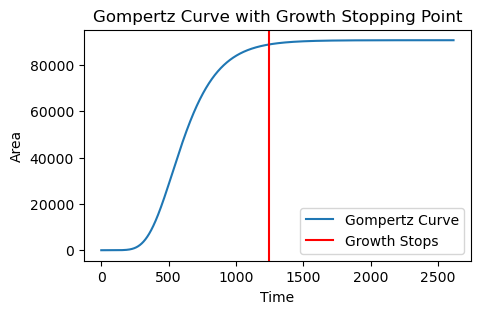

The colony stops growing around time: 1243
45


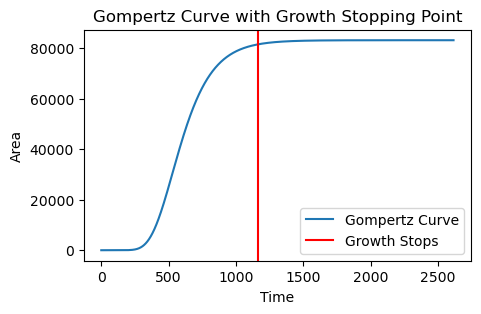

The colony stops growing around time: 1164
46


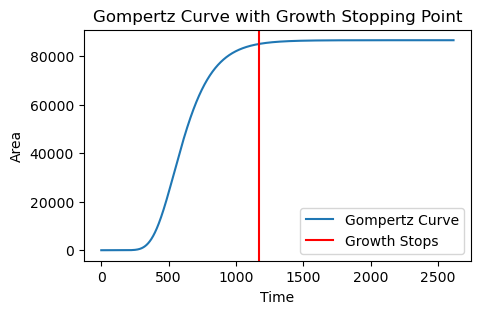

The colony stops growing around time: 1167
47


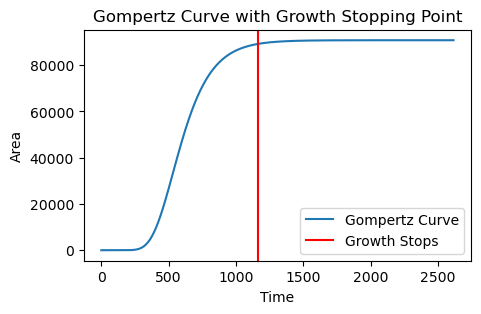

The colony stops growing around time: 1165
48


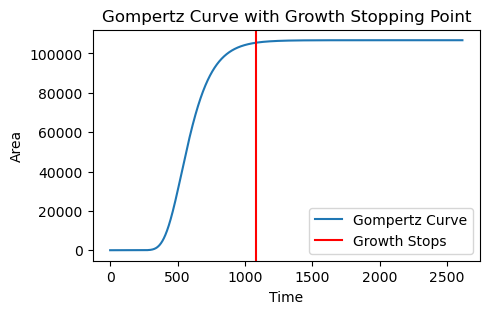

The colony stops growing around time: 1084
49


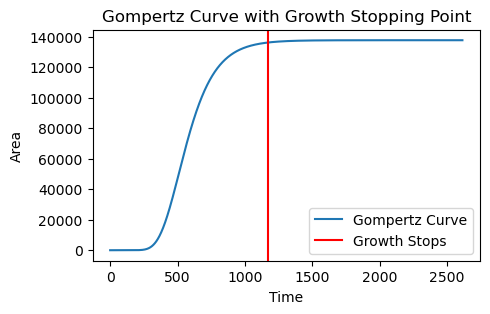

The colony stops growing around time: 1175
50


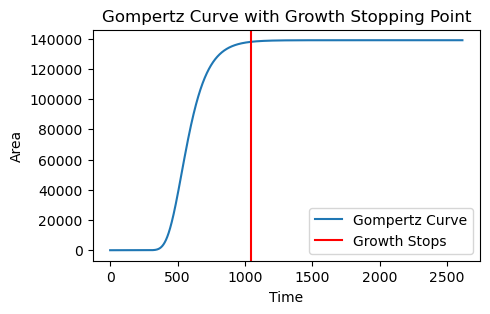

The colony stops growing around time: 1046
51


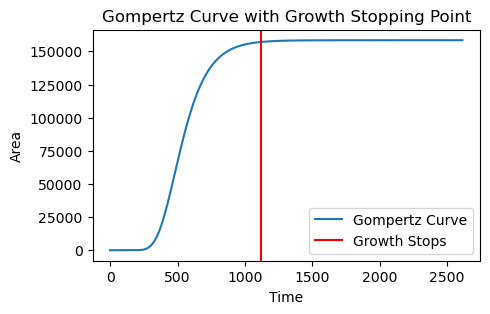

The colony stops growing around time: 1118
52


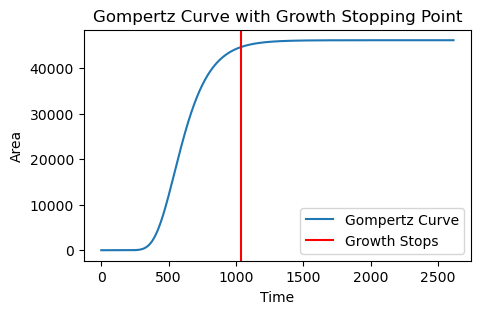

The colony stops growing around time: 1040
53


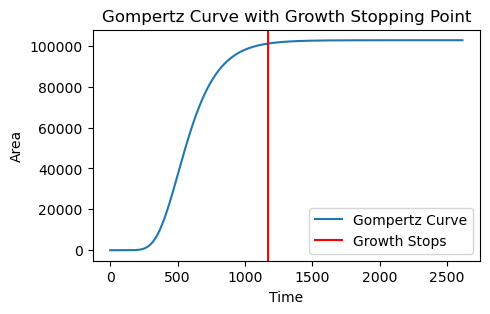

The colony stops growing around time: 1173
54


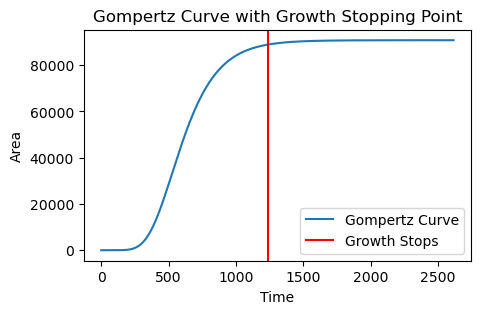

The colony stops growing around time: 1240
55


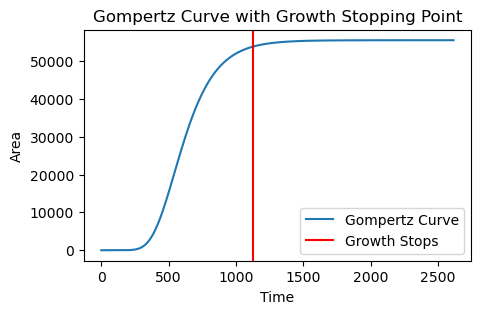

The colony stops growing around time: 1125
56


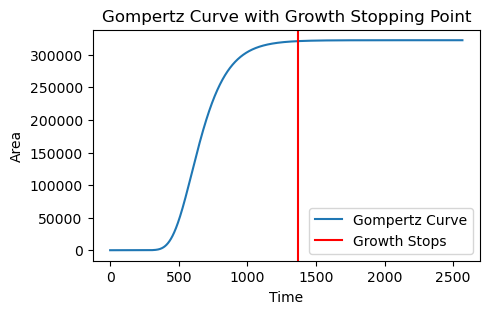

The colony stops growing around time: 1366
57


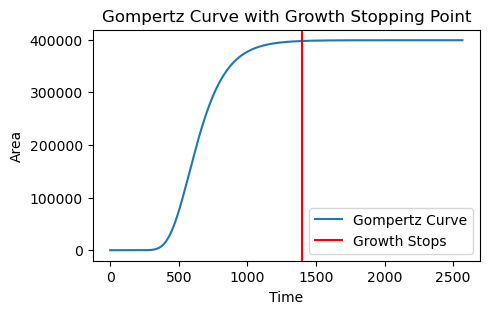

The colony stops growing around time: 1401
58


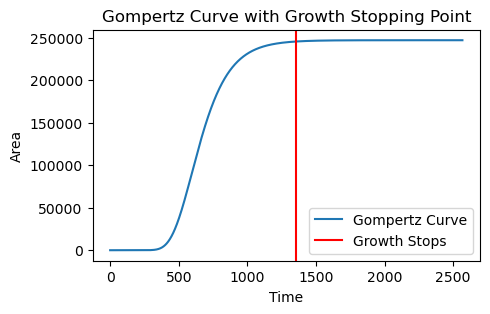

The colony stops growing around time: 1357
59


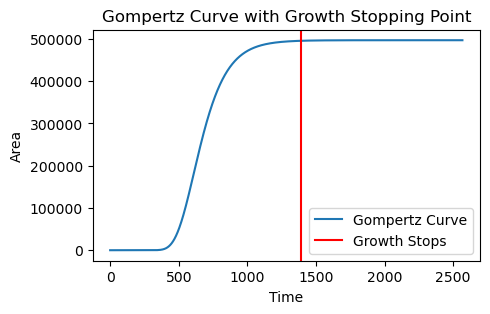

The colony stops growing around time: 1394
60


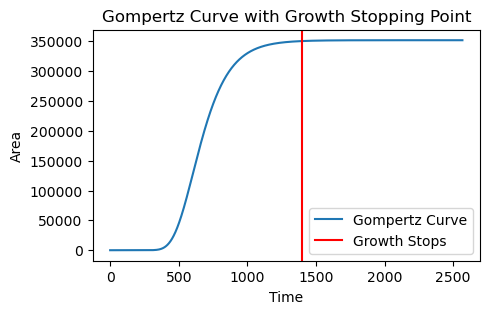

The colony stops growing around time: 1395
61


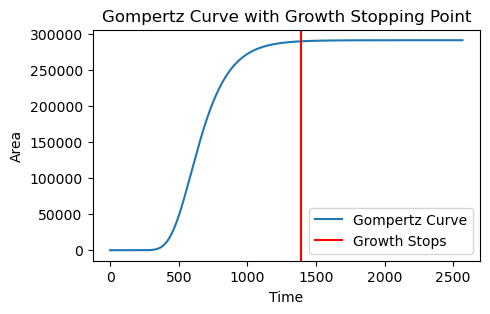

The colony stops growing around time: 1389
62


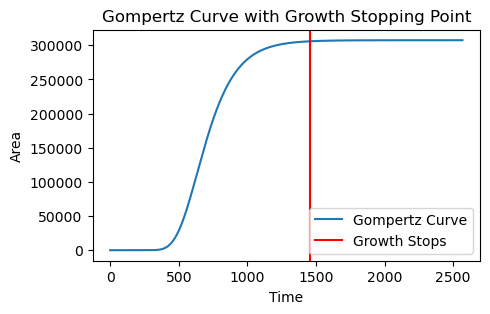

The colony stops growing around time: 1456
63


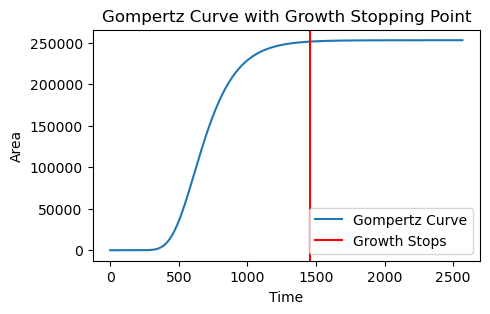

The colony stops growing around time: 1456
64


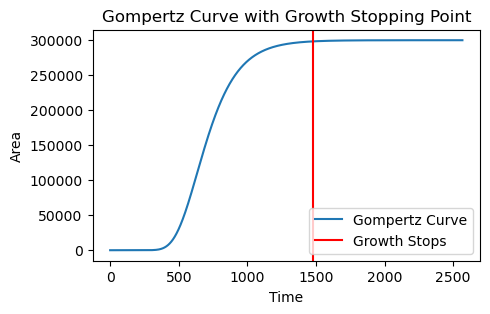

The colony stops growing around time: 1481
65


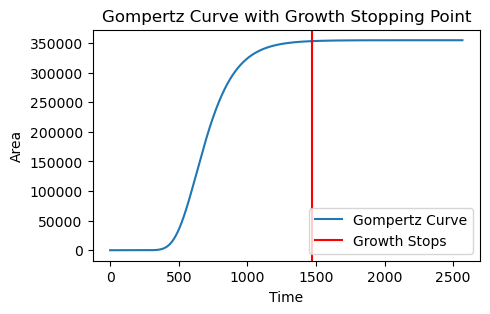

The colony stops growing around time: 1468
66


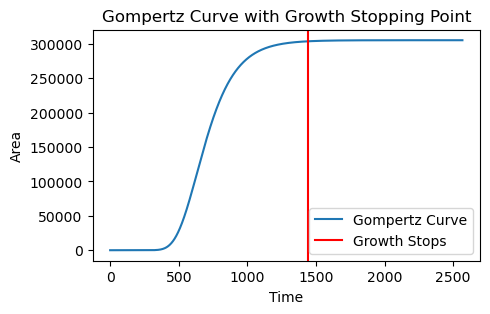

The colony stops growing around time: 1444
67


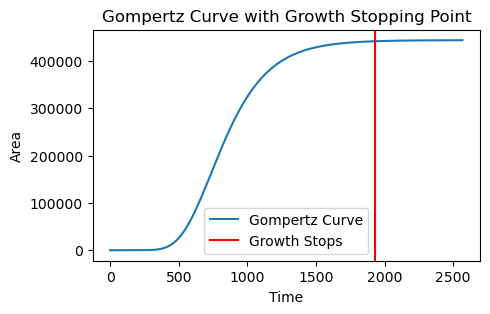

The colony stops growing around time: 1932
68


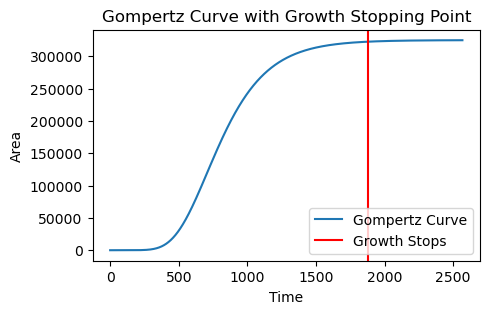

The colony stops growing around time: 1879
69


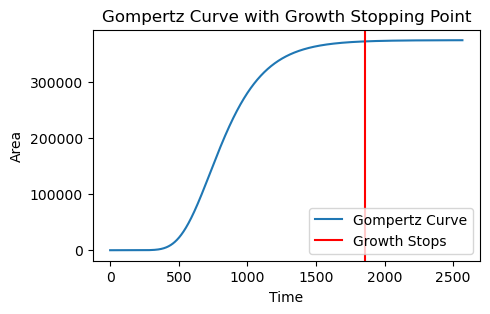

The colony stops growing around time: 1855
70


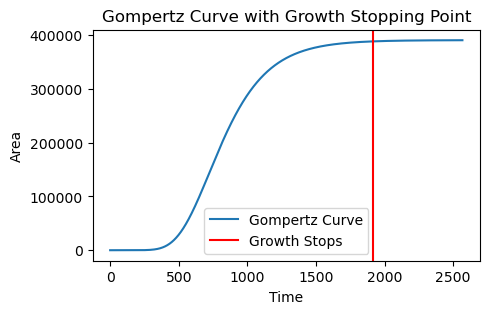

The colony stops growing around time: 1912
71


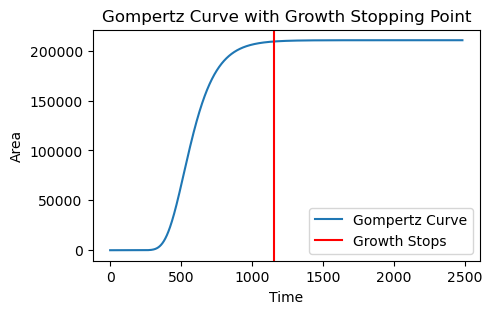

The colony stops growing around time: 1159
72


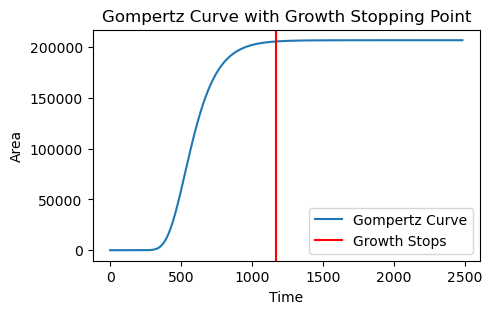

The colony stops growing around time: 1167
73


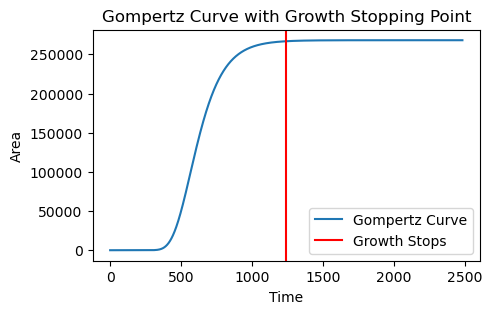

The colony stops growing around time: 1244
74


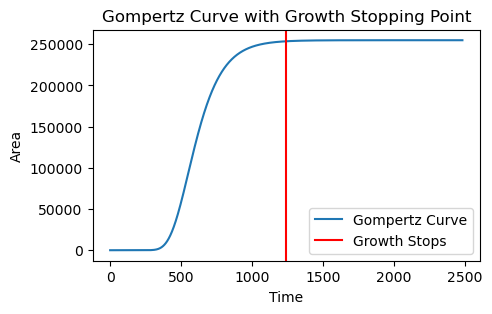

The colony stops growing around time: 1239
75


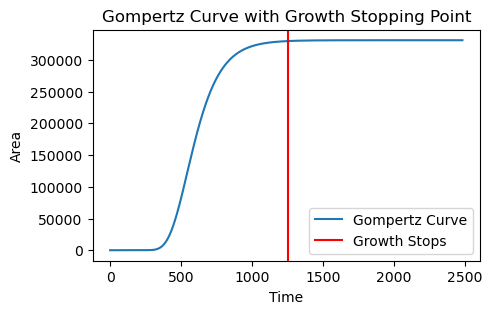

The colony stops growing around time: 1258
76


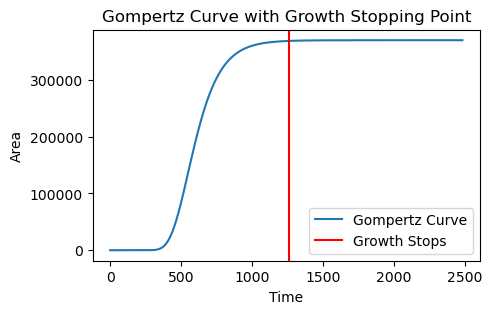

The colony stops growing around time: 1260
77


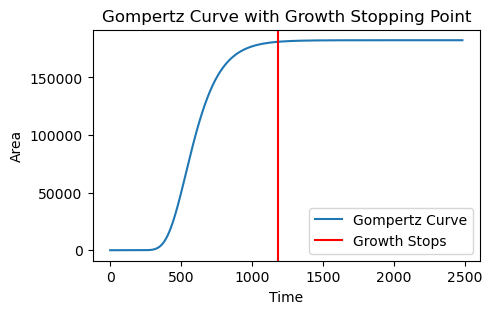

The colony stops growing around time: 1187
78


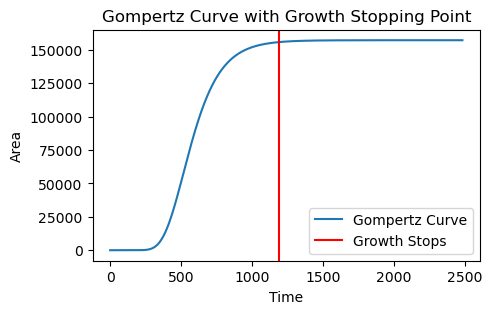

The colony stops growing around time: 1188
79


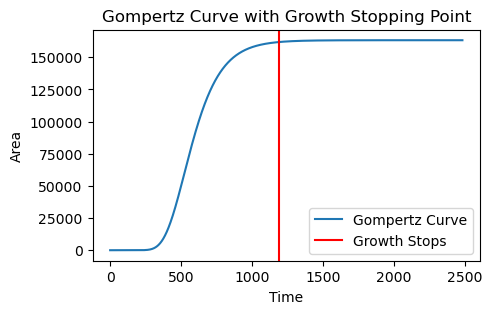

The colony stops growing around time: 1192
80


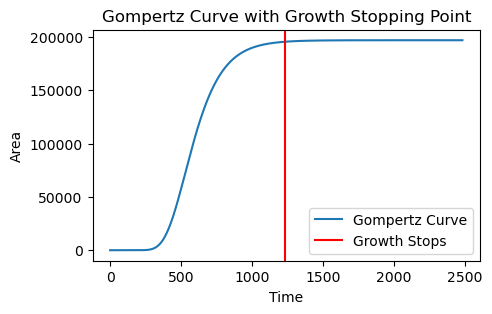

The colony stops growing around time: 1233
81


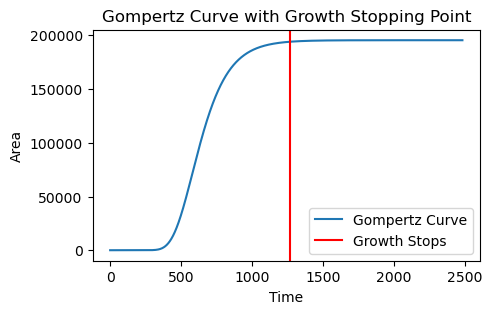

The colony stops growing around time: 1270
82


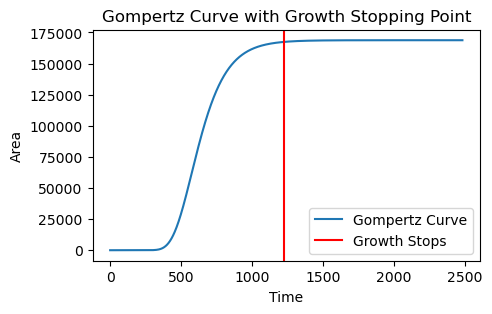

The colony stops growing around time: 1227
83


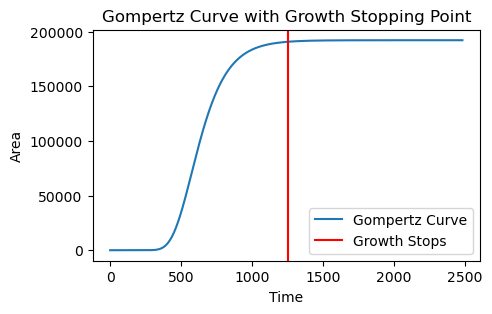

The colony stops growing around time: 1256
84


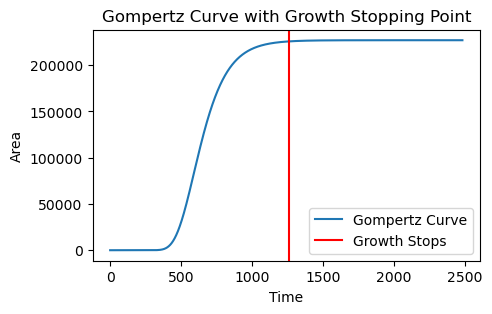

The colony stops growing around time: 1259
85


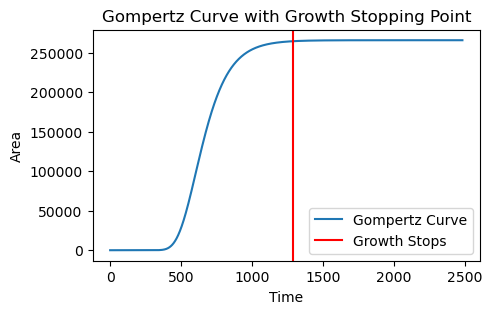

The colony stops growing around time: 1287
86


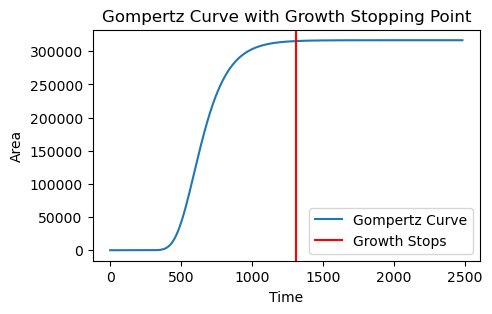

The colony stops growing around time: 1308
87


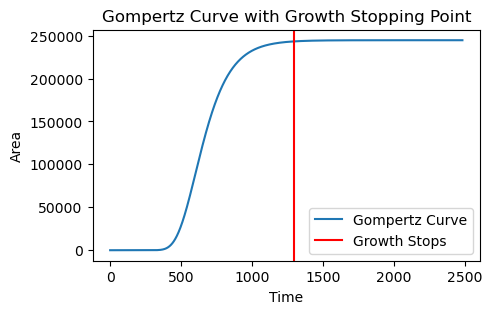

The colony stops growing around time: 1300
88


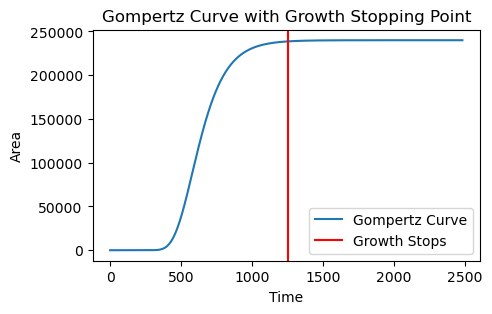

The colony stops growing around time: 1257
89


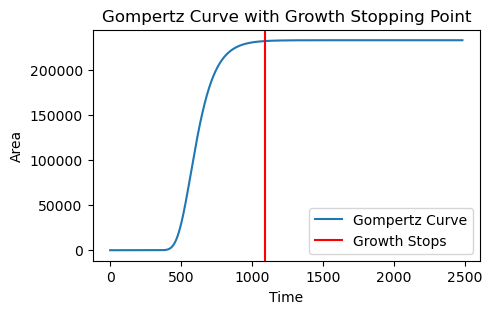

The colony stops growing around time: 1091
90


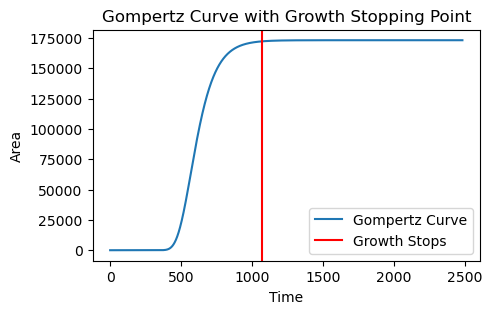

The colony stops growing around time: 1068
91


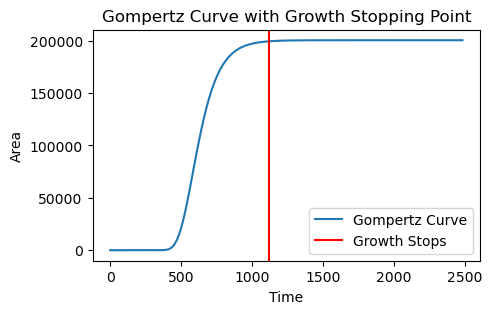

The colony stops growing around time: 1121
92


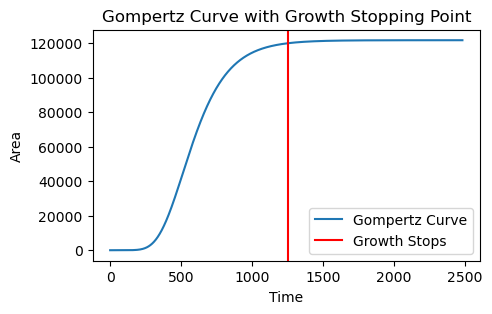

The colony stops growing around time: 1253
93


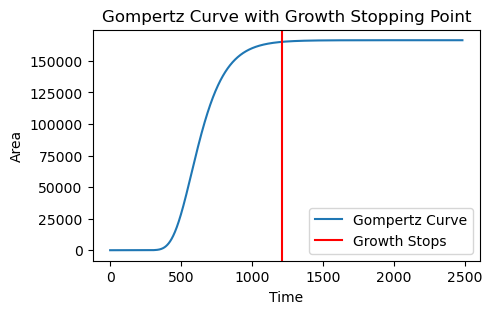

The colony stops growing around time: 1210
94


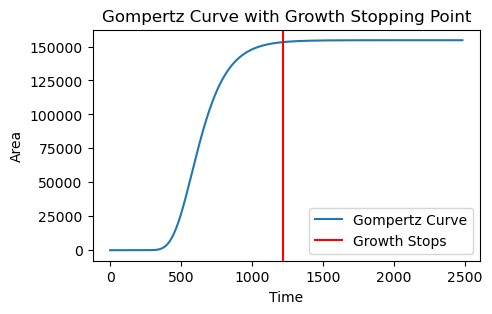

The colony stops growing around time: 1221
95


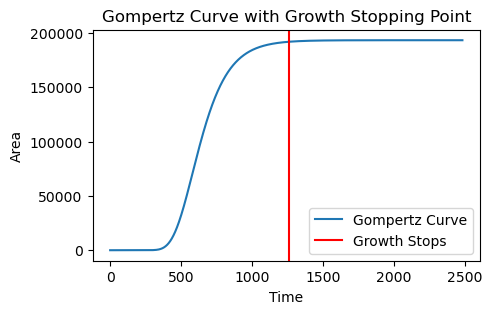

The colony stops growing around time: 1265
96


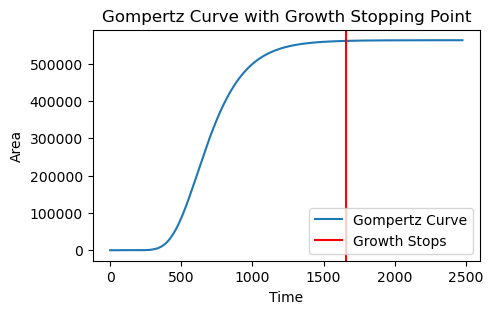

The colony stops growing around time: 1657
97


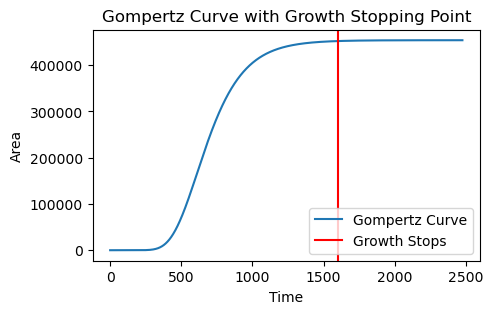

The colony stops growing around time: 1603
98


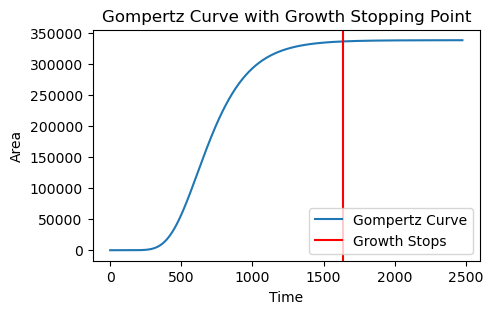

The colony stops growing around time: 1634
99


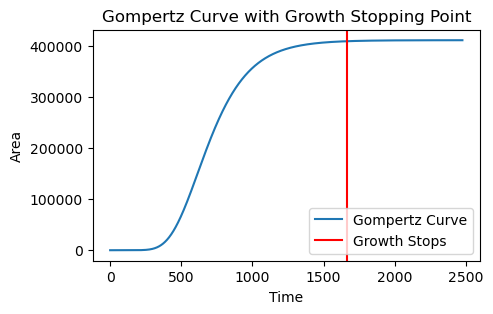

The colony stops growing around time: 1666
100


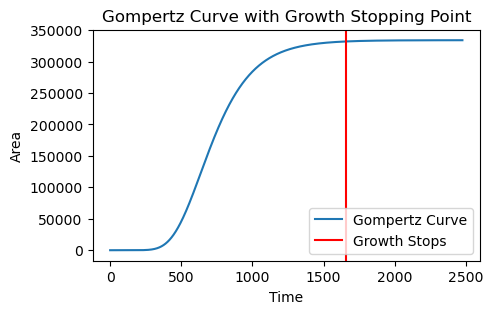

The colony stops growing around time: 1657
101


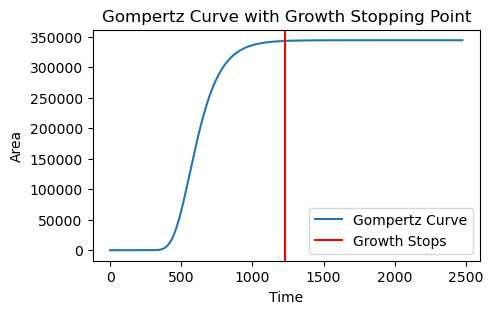

The colony stops growing around time: 1228
102


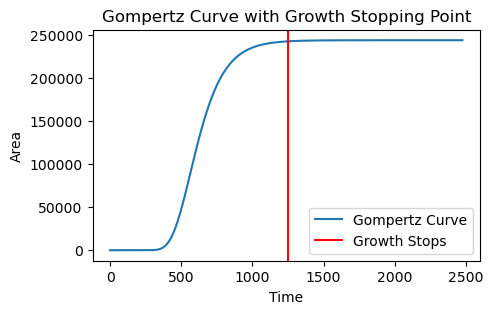

The colony stops growing around time: 1248
103


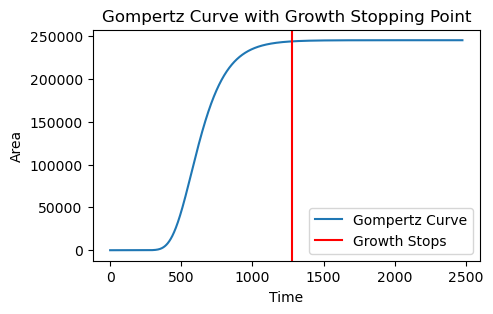

The colony stops growing around time: 1276
104


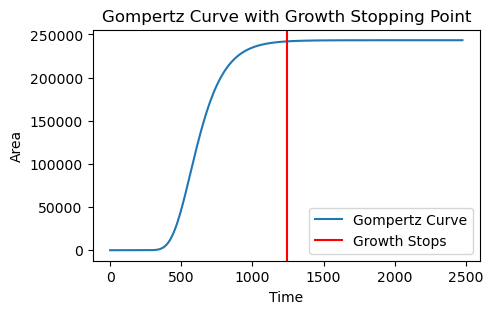

The colony stops growing around time: 1246
105


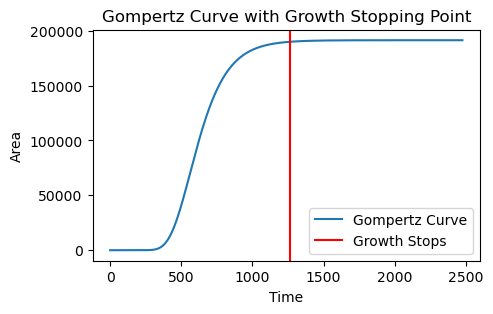

The colony stops growing around time: 1262
106


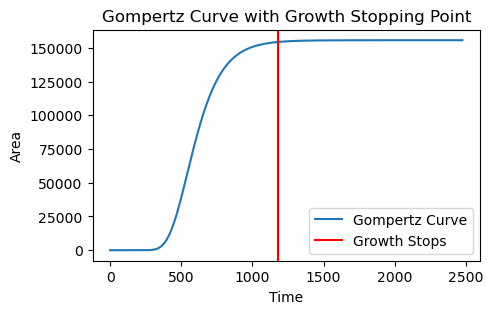

The colony stops growing around time: 1176
107


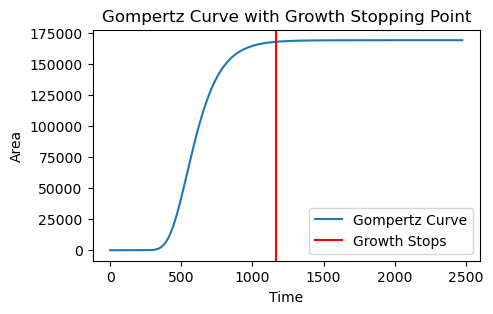

The colony stops growing around time: 1164
108


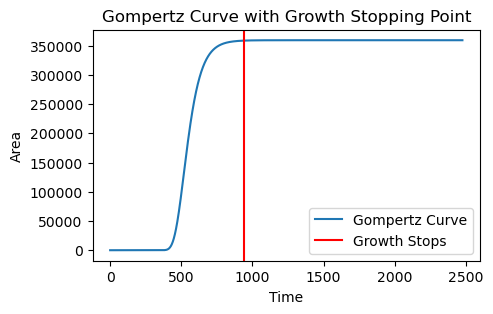

The colony stops growing around time: 941
109


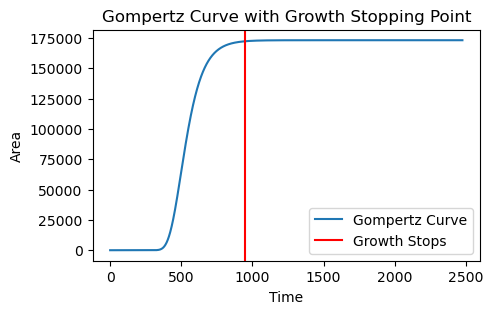

The colony stops growing around time: 949
110


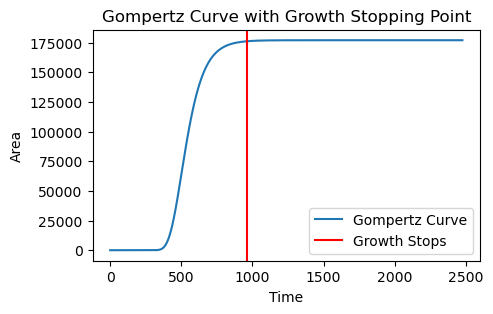

The colony stops growing around time: 962
111


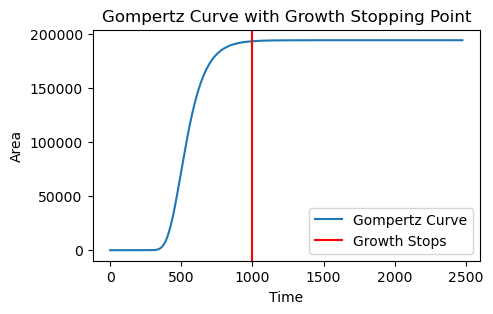

The colony stops growing around time: 999
112


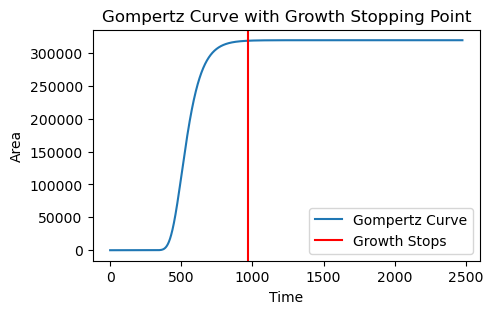

The colony stops growing around time: 969
113


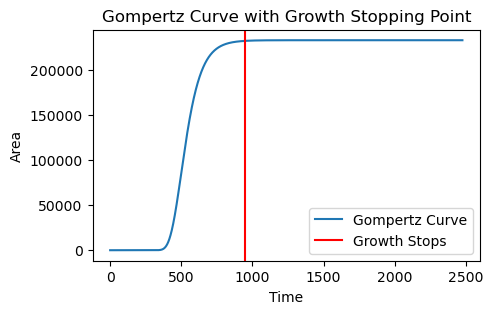

The colony stops growing around time: 944
114


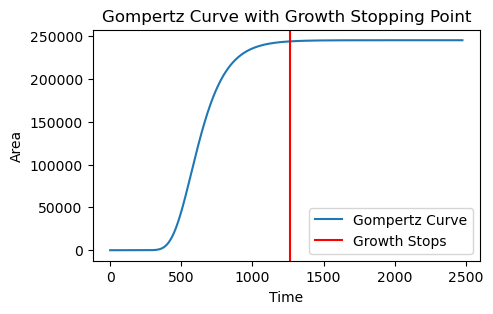

The colony stops growing around time: 1265
115


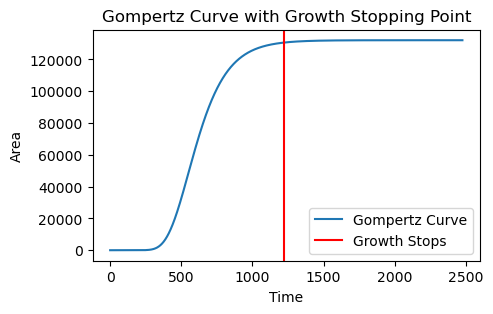

The colony stops growing around time: 1219
116


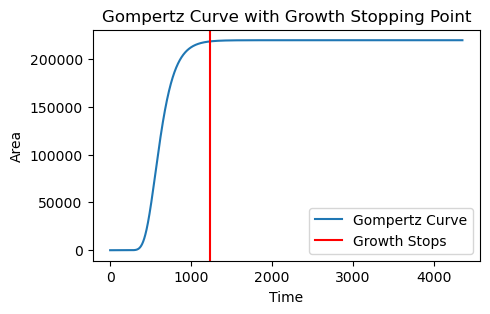

The colony stops growing around time: 1228
117


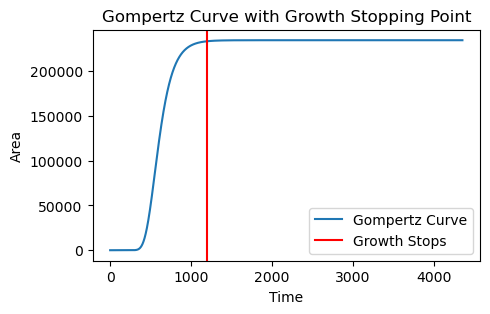

The colony stops growing around time: 1191
118


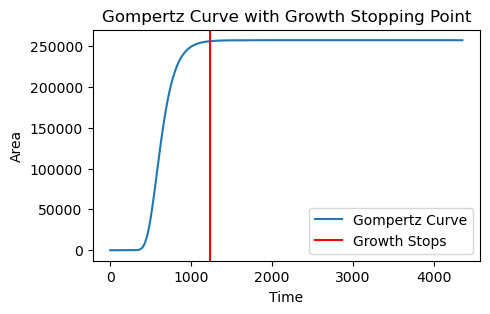

The colony stops growing around time: 1230
119


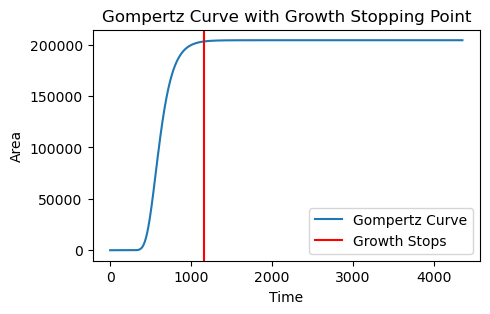

The colony stops growing around time: 1163
120


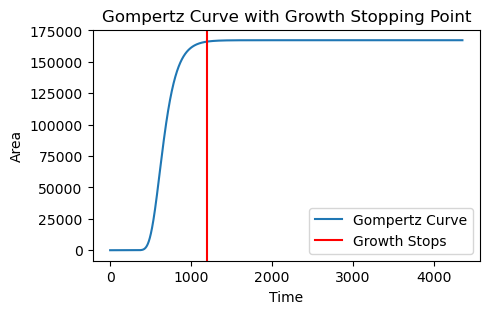

The colony stops growing around time: 1191
121


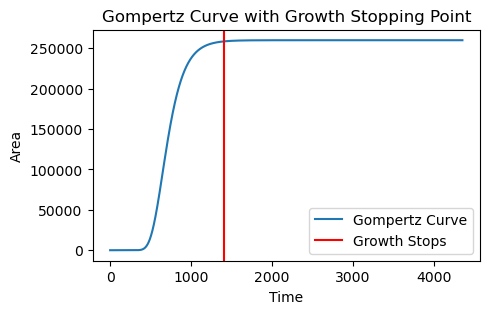

The colony stops growing around time: 1404
122


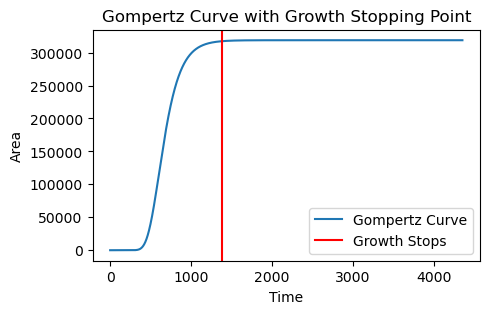

The colony stops growing around time: 1385
123


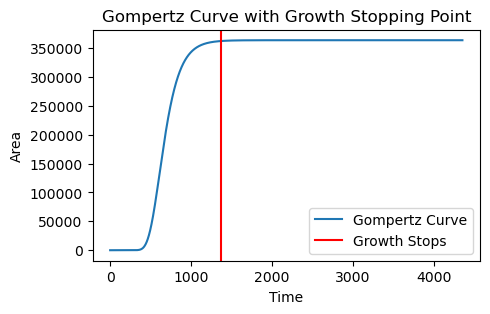

The colony stops growing around time: 1373
124


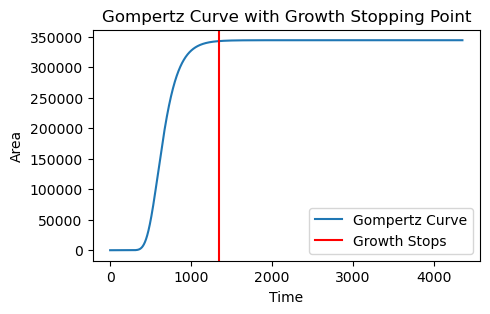

The colony stops growing around time: 1350
125


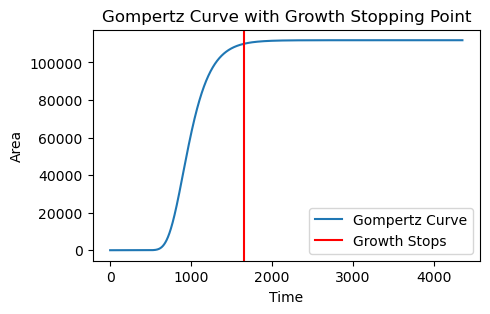

The colony stops growing around time: 1657
126


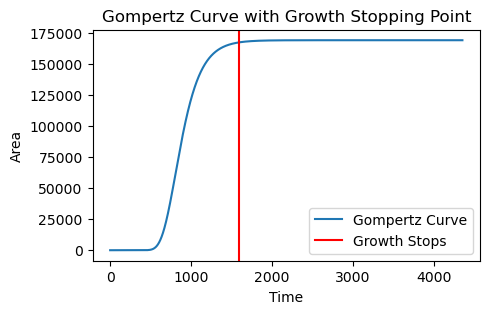

The colony stops growing around time: 1595
127


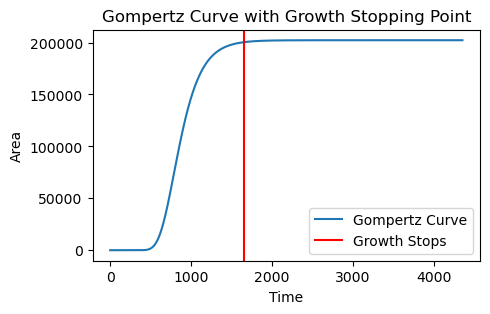

The colony stops growing around time: 1655
128


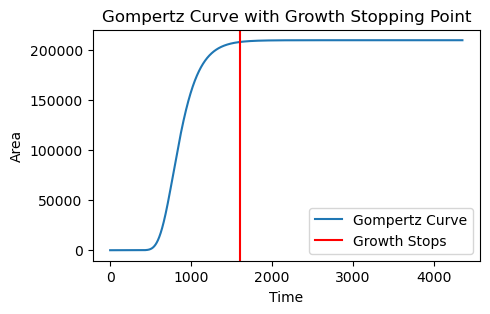

The colony stops growing around time: 1606
129


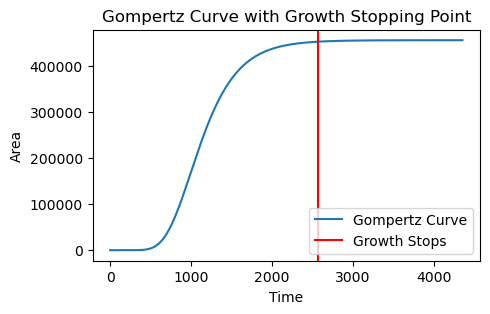

The colony stops growing around time: 2568
130


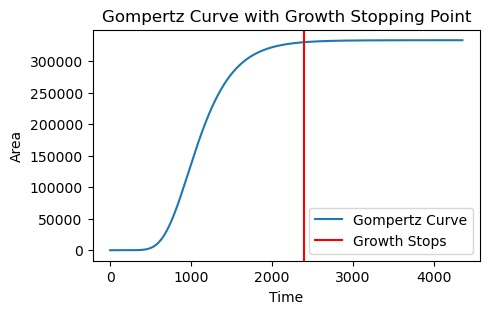

The colony stops growing around time: 2399
131


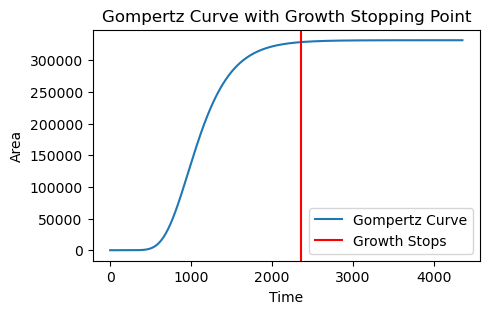

The colony stops growing around time: 2358
132


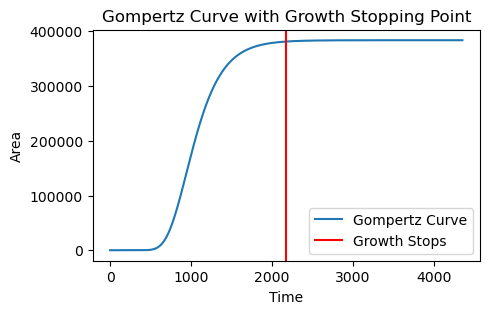

The colony stops growing around time: 2172
133


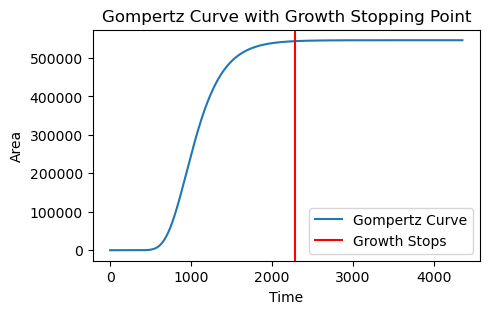

The colony stops growing around time: 2278
134


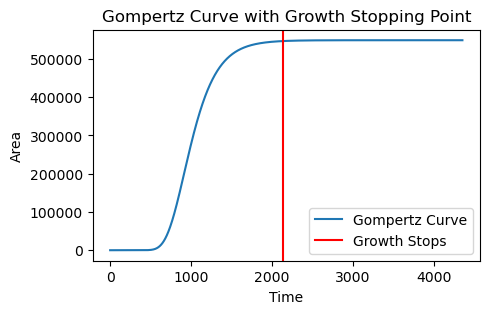

The colony stops growing around time: 2134
135


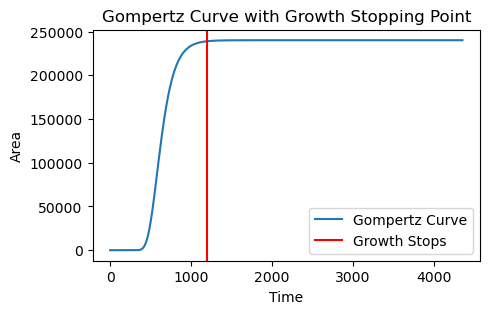

The colony stops growing around time: 1197
136


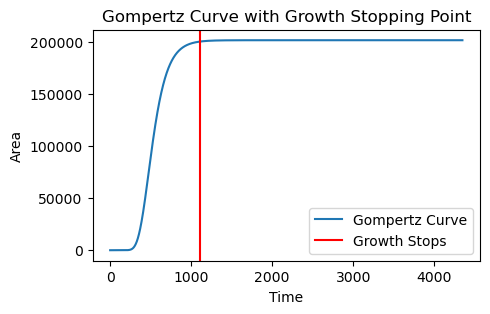

The colony stops growing around time: 1113
137


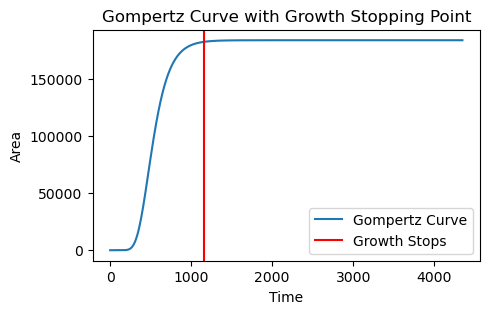

The colony stops growing around time: 1158
138


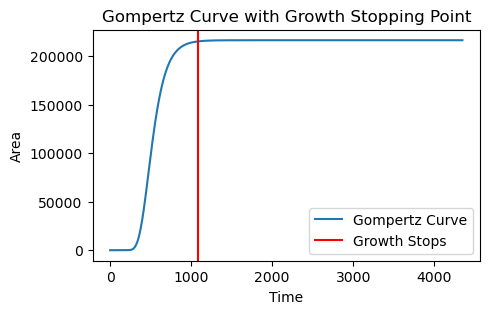

The colony stops growing around time: 1087
139


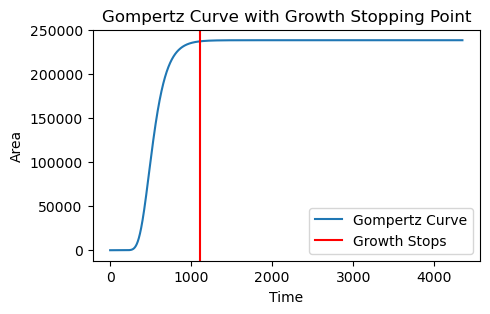

The colony stops growing around time: 1115
140


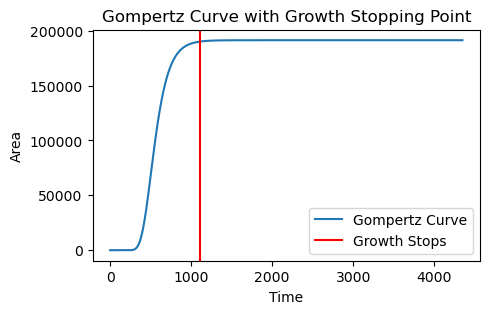

The colony stops growing around time: 1111
141


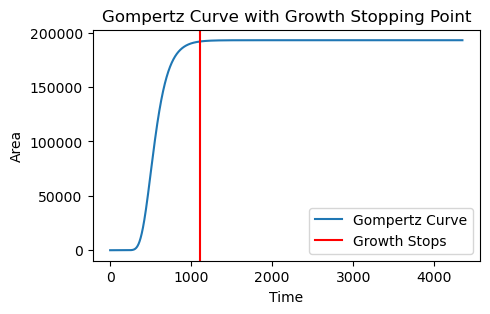

The colony stops growing around time: 1107
142


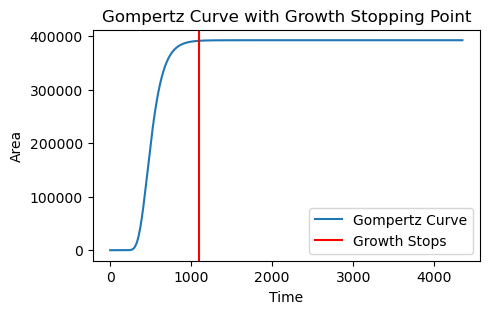

The colony stops growing around time: 1097
143


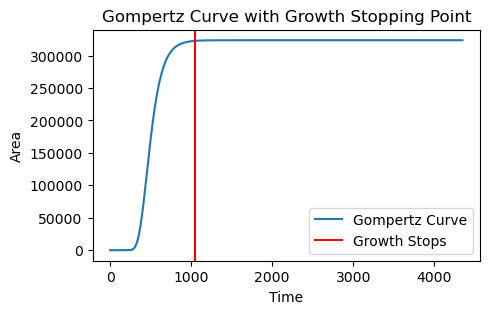

The colony stops growing around time: 1045
144


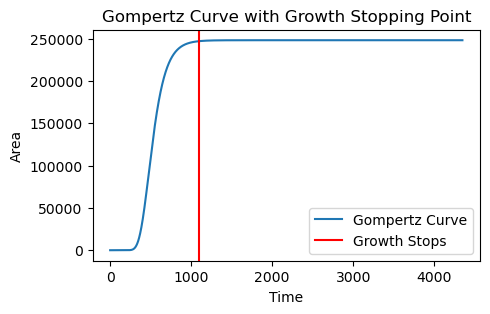

The colony stops growing around time: 1095
145


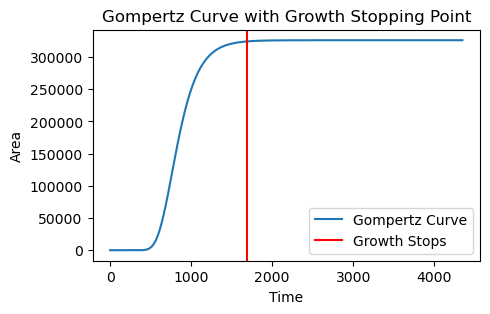

The colony stops growing around time: 1695
146


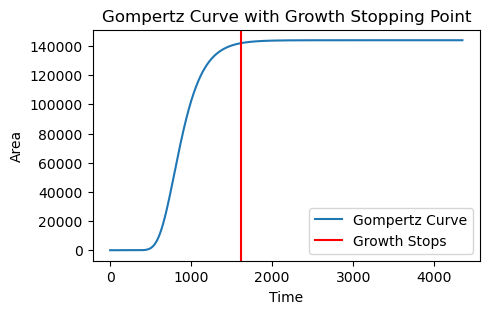

The colony stops growing around time: 1621
147


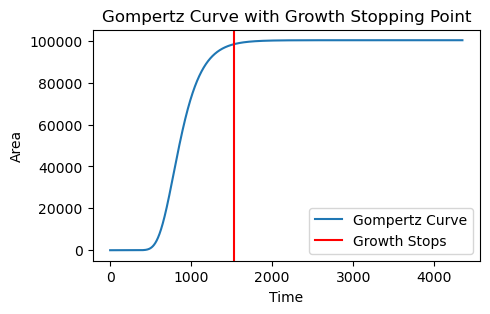

The colony stops growing around time: 1529
148


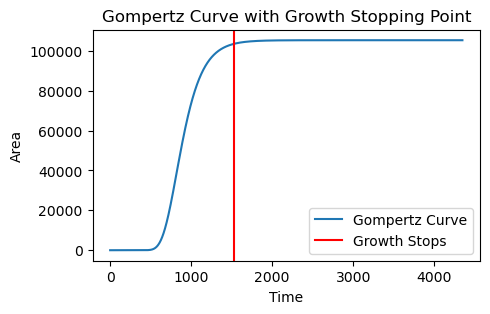

The colony stops growing around time: 1534
149


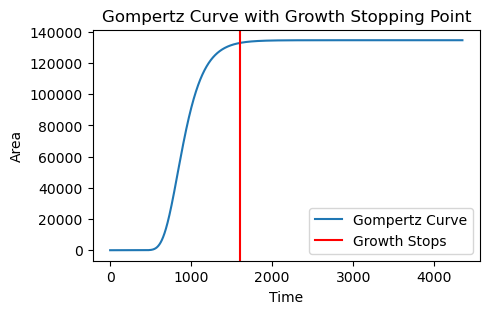

The colony stops growing around time: 1598
150


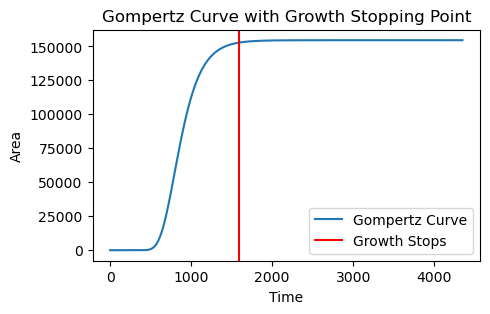

The colony stops growing around time: 1588
151


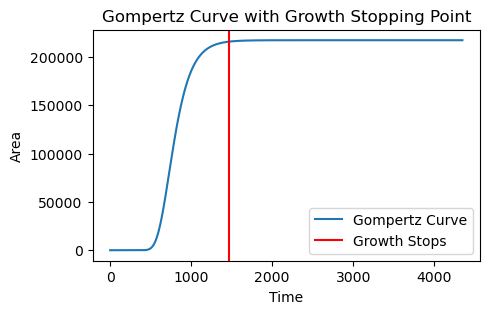

The colony stops growing around time: 1465
152


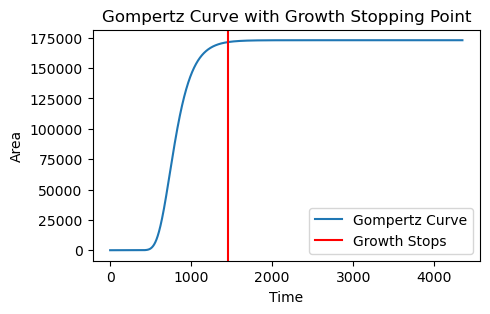

The colony stops growing around time: 1456
153


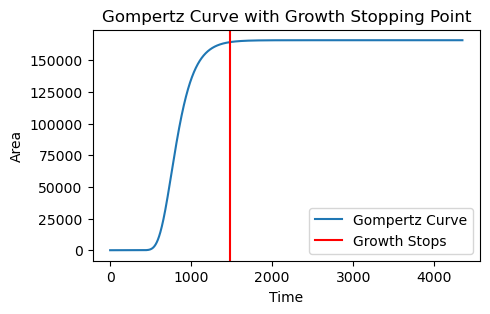

The colony stops growing around time: 1475
154


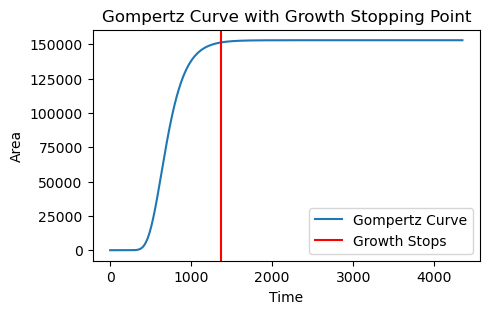

The colony stops growing around time: 1368
155


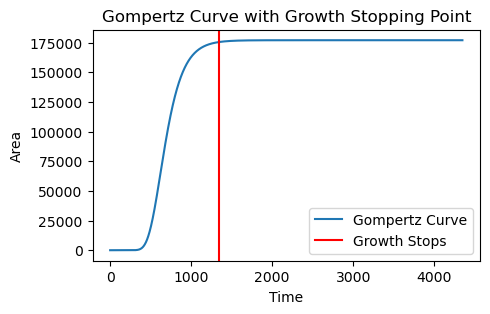

The colony stops growing around time: 1345
156


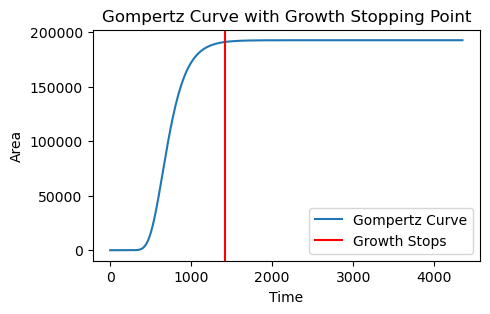

The colony stops growing around time: 1417
157


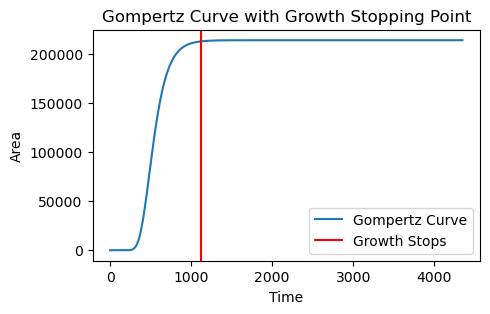

The colony stops growing around time: 1116
158


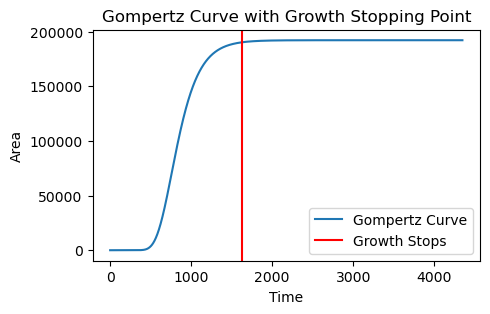

The colony stops growing around time: 1628
159


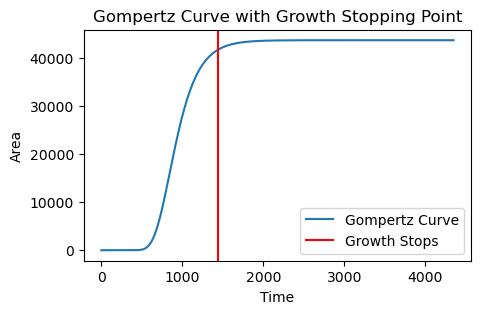

The colony stops growing around time: 1440


In [17]:
for i in df.index.values:
    print(i)
    params = [df.loc[i,'A_gomp_um'],df.loc[i,'mu_gomp_um'],df.loc[i,'l_gomp_um']]
    incub_time_s = datetime.strptime(df.loc[i,'t_im'], '%H:%M:%S') - datetime.strptime(df.loc[i,'t_incub'], '%H:%M:%S')
    incub_time_n = incub_time_s.seconds / 60 ## time in minutes
    tf = int(incub_time_n + df.loc[i, 'exp length']*10) # end of the experiment
    
    time = np.arange(0, tf)
    gomp = gompertz(time, *params)  # Gompertz curve based on fitted parameters
    
    ggr = savgol_filter(gomp, 21, 1, deriv=1) # derivative of the Gompertz curve (growth rate)
    max_growth_idx = np.argmax(ggr)
    
    # threshold for when the growth rate is considered to have stopped
    threshold = 10 # this is about 10 um  
    
    # find where growth rate drops below the threshold after the period of max growth
    stopping_idx = np.where((ggr[max_growth_idx:] < threshold))[0]
    
    # Add max_growth_idx to the stopping_idx to get the correct position in the original array
    if stopping_idx.size > 0:
        stopping_idx = stopping_idx[0] + max_growth_idx  # First point after max growth where ggr < threshold
    else:
        stopping_idx = len(time) - 1  # If no point is found, set it to the end of the time range
    
    stopping_time = time[stopping_idx]
    df.at[i, 'gomp_growth_stops_10'] = stopping_time
    plt.figure(figsize=(5,3))

    plt.plot(time, gomp, label='Gompertz Curve')
    
    # Mark the stopping point
    #plt.scatter(stopping_time, gomp[stopping_idx], color='red', zorder=5, label='Growth Stops')
    plt.axvline(stopping_time, color='red', label='Growth Stops')
    # Label and title
    plt.xlabel('Time')
    plt.ylabel('Area')
    plt.title('Gompertz Curve with Growth Stopping Point')
    plt.legend()
    
    # Show the plot
    plt.show()
    
    # Output the result
    print(f"The colony stops growing around time: {stopping_time}")


In [18]:
#df.to_excel('../data_processed.xlsx', index=False)

Text(0, 0.5, 'Max area [$\\mu m^2$]')

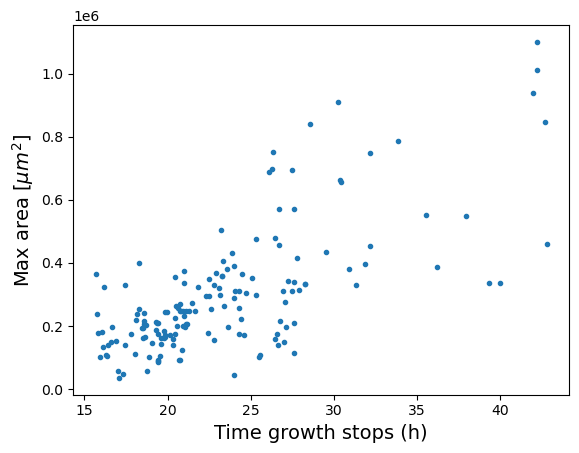

In [14]:
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim([0,2700])
plt.plot(df['gomp_growth_stops_10'] / 60,df['area_max_um'],'.')
plt.xlabel('Time growth stops (h)',fontsize=14)
plt.ylabel('Max area [$\mu m^2$]',fontsize=14)

Text(0.5, 0, 'N')

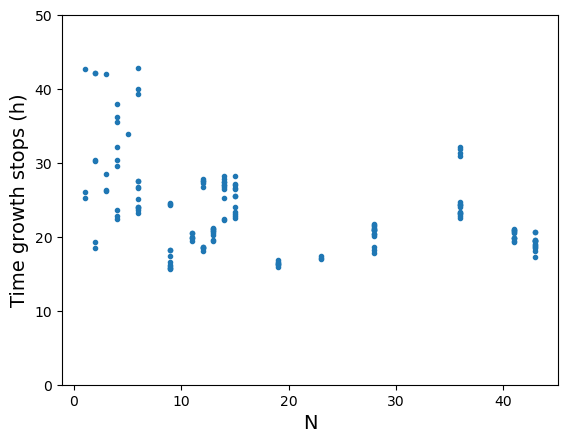

In [16]:
plt.plot(df_N_A_gomp_all_pos['total_colonies'],df['gomp_growth_stops_10']/60,'.')
plt.ylabel('Time growth stops (h)',fontsize=14)
plt.ylim([0,50])
plt.xlabel('N',fontsize=14)

#### $t_m$

In [21]:
for i in df.index.values:
    params = [df.loc[i,'A_gomp_um'],df.loc[i,'mu_gomp_um'],df.loc[i,'l_gomp_um']]
    tm = tm_gomp(*params)
    df.loc[i,'tm_um'] = tm

In [22]:
#df.to_excel('../data_processed.xlsx', index=False)

Text(0.5, 0, '$t_m$ [h]')

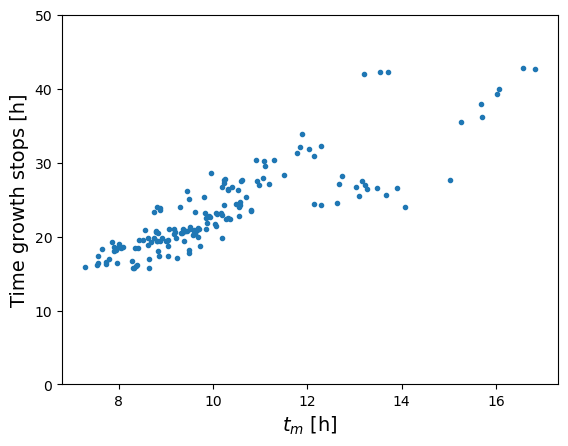

In [53]:
plt.plot(df['tm']/60,df['gomp_growth_stops_10']/60,'.')
plt.ylabel('Time growth stops [h]',fontsize=14)
plt.ylim([0,50])
plt.xlabel('$t_m$ [h]',fontsize=14)

(0.0, 30.0)

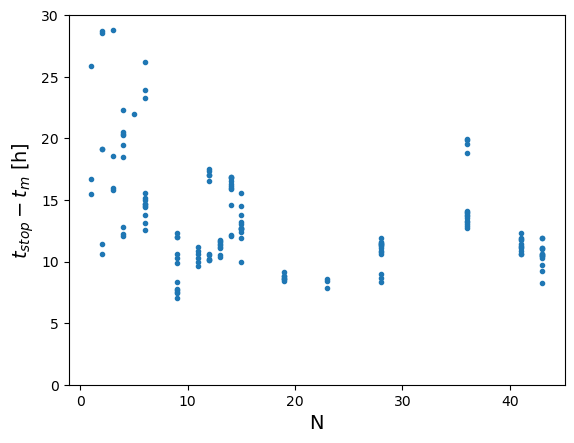

In [64]:
## is there a constant value for tstop - tm?
plt.plot(df_N_A_gomp_all_pos['total_colonies'],df['gomp_growth_stops_10']/60-df['tm']/60, '.')
plt.xlabel('N', fontsize=14)
plt.ylabel('$t_{stop} - t_m$ [h]', fontsize=14)
plt.ylim([0,30])

(0.0, 36.0)

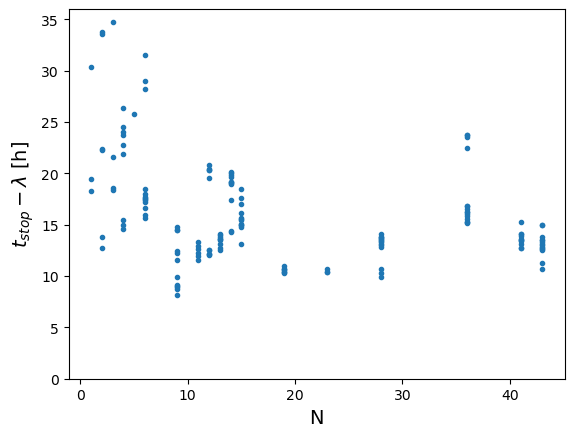

In [63]:
## is there a constant value for tstop - lambda?
plt.plot(df_N_A_gomp_all_pos['total_colonies'],df['gomp_growth_stops_10']/60-df['l_gomp_um']/60, '.')
plt.xlabel('N', fontsize=14)
plt.ylabel('$t_{stop} - \lambda$ [h]', fontsize=14)
plt.ylim([0,36])

Text(0, 0.5, '$t_{stop} - \\lambda$ [h]')

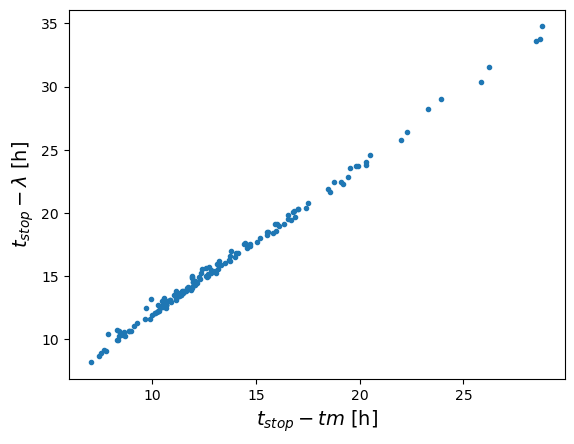

In [62]:
## is there a constant value for tstop - lambda?
plt.plot(df['gomp_growth_stops_10']/60-df['tm']/60,df['gomp_growth_stops_10']/60-df['l_gomp_um']/60, '.')
plt.xlabel('$t_{stop} - tm$ [h]', fontsize=14)
plt.ylabel('$t_{stop} - \lambda$ [h]', fontsize=14)

Text(0, 0.5, '$\\lambda$ [h]')

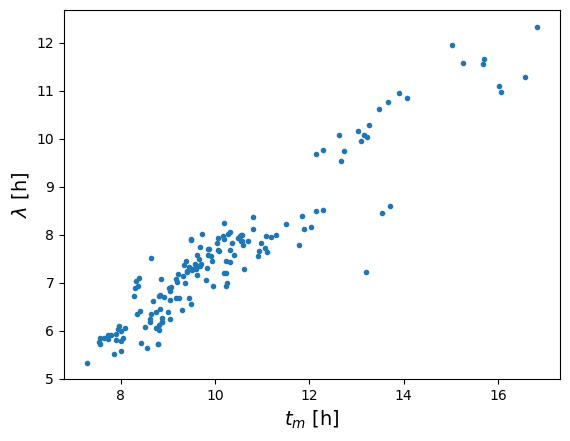

In [67]:
## is there a constant value for tstop - lambda?
plt.plot(df['tm']/60,df['l_gomp_um']/60, '.')
plt.xlabel('$t_m$ [h]', fontsize=14)
plt.ylabel('$\lambda$ [h]', fontsize=14)

In [ ]:
## is there a constant value for tstop - tm?
plt.plot(df['gomp_growth_stops_10']/60-df['tm']/60, '.')

Text(0.5, 0, 'N')

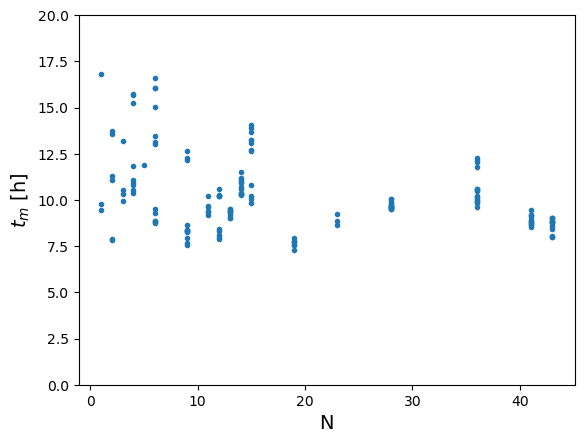

In [27]:
plt.plot(df_N_A_gomp_all_pos['total_colonies'],df['tm']/60,'.')
plt.ylabel('$t_m$ [h]',fontsize=14)
plt.ylim([0,20])
plt.xlabel('N',fontsize=14)

Text(0.5, 0, '$t_m$ [h]')

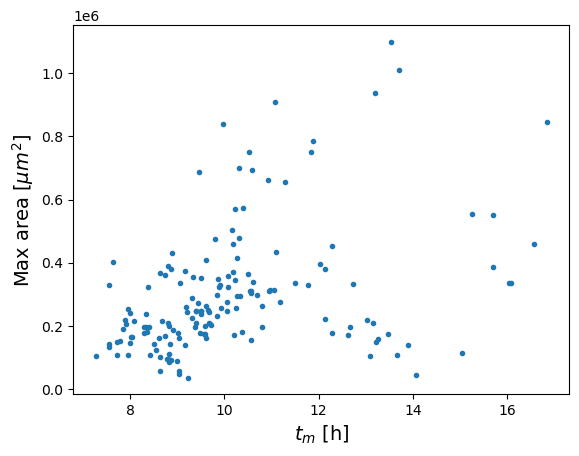

In [29]:
plt.plot(df['tm']/60,df['area_max_um'],'.')
plt.ylabel('Max area [$\mu m^2$]',fontsize=14)
#plt.ylim([0,50])
plt.xlabel('$t_m$ [h]',fontsize=14)

Text(0.5, 0, '$t_m$ [h]')

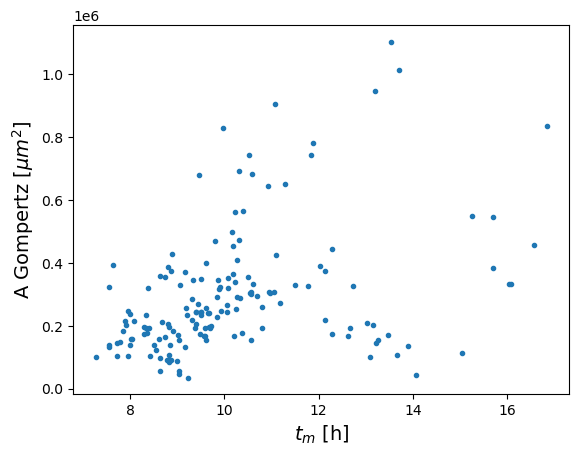

In [38]:
plt.plot(df['tm']/60,df['A_gomp_um'],'.')
plt.ylabel('A Gompertz [$\mu m^2$]',fontsize=14)
#plt.xlim([0,18])
plt.xlabel('$t_m$ [h]',fontsize=14)

Text(0.5, 0, '$t_m$ [h]')

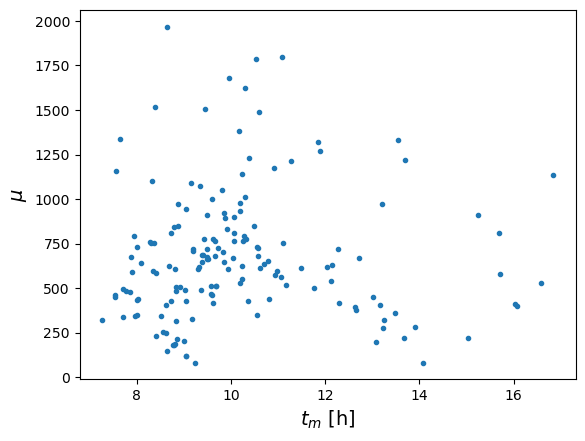

In [43]:
#plt.yscale('log')
plt.plot(df['tm']/60,df['mu_gomp_um'],'.')
plt.ylabel('$\mu$',fontsize=14)
#plt.ylim([0,20])
plt.xlabel('$t_m$ [h]',fontsize=14)

Text(0.5, 0, '$t_m$ [h]')

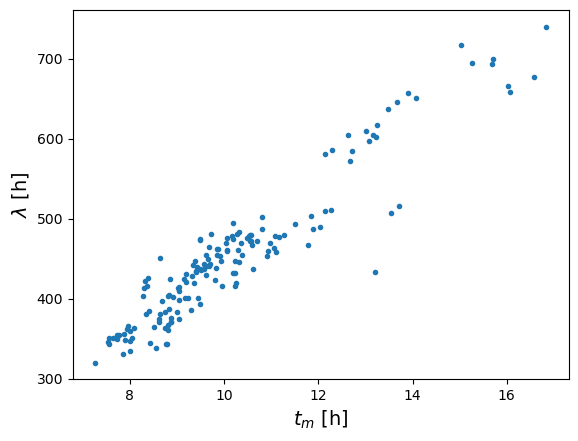

In [37]:
plt.plot(df['tm']/60,df['l_gomp_um']/60,'.')
plt.ylabel('$\lambda$ [h]',fontsize=14)
#plt.ylim([0,20])
plt.xlabel('$t_m$ [h]',fontsize=14)